In [11]:
##################################
### Import the usual libraries ###
##################################

### Other
import warnings
warnings.filterwarnings('ignore')

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 30})

from tqdm import tqdm_notebook

from astropy.io import fits

In [12]:
class WhatsMyAgeAgain():
    '''
    Class to calculate a star's age and extinction using PARSEC isochrones and extinction law
    from Cardelli et al. 1989
    '''
    def __init__(self,mh,am,distance,isochrones):
        
        '''
        feh: [float] metallicity [M/H] of star
        am: [float] [$\alpha$/M] of star
        distance: [float] distance to star in pc
        isochrones: [astropy Table] PARSEC isochrone table
        '''
        
        # stellar parameters
        self.salfeh = mh+np.log10(0.638*(10**am)+0.362) #Salaris et al. 1993
        self.dist = distance
        
        # PARSEC isochrones
        self.distmod = 5.0*np.log10(distance)-5.0
        
        # PARSEC isochrones
        self.labels = ['Jmag','Hmag','Ksmag']
        
        self.uniq_ages = np.unique(isochrones['logAge'])
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
                
        # Effective Wavelengths of different passbands
        self.leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757} # mircons
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value
        
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        '''
        
        data = np.asarray(data)
    
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value
    
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        
        Output:
        ------
            close1: closest value under the given value
            close2: closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    def cardelli_a(self,x):
        '''
        a(x) function from Cardelli et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            a: a function value  
        '''
        if 0.3 <= x < 1.1:
            a = 0.574*(x**1.61)
            return a
    
        elif 1.1 <= x < 3.3:
            y = x - 1.82
            a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                 0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
            return a
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
                return a
        
            else:
                fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
                return a       
    
    def cardelli_b(self,x):
        '''
        b(x) function from Cardelli et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            b: b function value 
        '''
        if 0.3 <= x < 1.1:
            b = -0.527*(x**1.61)
            return b
    
        elif 1.1 <= x <= 3.3:
            y = x - 1.82
            b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                 0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
            return b
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
                return b
        
            else:
                fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
                return b
    
    def cardelli_alav(self,wave,rv):
        '''
        Calculate A\lambda/Av
    
        Inputs:
        ------
            wave: effective wavelength in units of micron
            rv: Rv value (=Av/E(B_V))
        
        Output:
        ------
            alav: A\lambda/Av
        '''
        x=1/wave
        alav = self.cardelli_a(x)+self.cardelli_b(x)/rv
        return alav
        
    def InitialAge(self,teff,kmag,ak):
        '''
        Calculate an initial guess for the age of a star
        
        Inputs:
        ------
            teff: temperature of a star
            kmag: K magnitude of a star
            ak: the extinction in the 2MASS K band
        
        Output:
        ------
            age_guess: initial guess for age
        
        '''
        
        iso_ = self.iso[np.where(self.iso['MH']==self.closest(self.iso['MH'],self.salfeh))]
        
        euclid = (np.subtract(iso_['Ksmag'],kmag-ak-self.distmod)**2+
                  np.subtract(10**iso_['logTe'],teff)**2)
        
        age_guess = np.median(10**iso_['logAge'][euclid.argmin()]/10**9)
        
#         print(iso_['Ksmag'][euclid.argmin()])
#         print(10**iso_['logTe'][euclid.argmin()])
        
        return age_guess    
        
    def Teff2AppMags(self,teff,age,ak):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: temperature of star
            age: age of star
            ak: extinction in the 2MASS K band
            
            # parameters defined in __init__
            self.dist: distance to star
            self.iso: set of PARSEC isochrones
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        ajak = self.cardelli_alav(self.leff['J'],3.1)/self.cardelli_alav(self.leff['K'],3.1)
        ahak = self.cardelli_alav(self.leff['H'],3.1)/self.cardelli_alav(self.leff['K'],3.1)
        
        extincts = np.array([ajak,ahak,1.0])*ak
        
        lgage = np.log10(age*10**9)
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
#             print('in: ',age)
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                return np.array([999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            _, uidx = np.unique(slogTe,return_index=True)
            slogTe = slogTe[uidx]
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(3)
            for i in range(3):
                mag_spl = InterpolatedUnivariateSpline(slogTe,iso_[self.labels[i]][sidx][uidx])
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
            
#             print('Calculated Apparent J: {:.3f} H: {:.3f} K: {:.3f}'.format(j_app,h_app,k_app))
#             print('ak: {:.3f}'.format(ak))
#             print('---')
            
            return calc_mags
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            
#             print('age: ',age)
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                return np.array([999999.0, 999999.0, 999999.0])
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                return np.array([999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            
            # younger
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            slogTe_lo = slogTe_lo[uidx_lo]
            
            # older
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            slogTe_hi = slogTe_hi[uidx_hi]
            
            ### use a spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(3)
            for i in range(3):
                mag_spl_lo = InterpolatedUnivariateSpline(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
                mag_spl_hi = InterpolatedUnivariateSpline(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.polyfit([age_lo,age_hi],[mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1))
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
            
#             print('Calculated Apparent J: {:.3f} H: {:.3f} K: {:.3f}'.format(j_app,h_app,k_app))
#             print('ak: {:.3f}'.format(ak))
#             print('---')
            
            return calc_mags

In [13]:
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def cardelli_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def cardelli_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def cardelli_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = cardelli_a(x)+cardelli_b(x)/rv
    return alav

ejk_ak = (cardelli_alav(leff['J'],3.1)-cardelli_alav(leff['K'],3.1))/cardelli_alav(leff['K'],3.1)

In [14]:
print('aj_ak',cardelli_alav(leff['J'],3.1)/cardelli_alav(leff['K'],3.1))
print('ah_ak',cardelli_alav(leff['H'],3.1)/cardelli_alav(leff['K'],3.1))

aj_ak 2.490197238236482
ah_ak 1.5773727079807909


# Parsec

In [15]:
# massive
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive.fits.gz',0)
massive = massive[np.where(massive['label']==3.0)]
massive = massive[np.argsort(massive['logAge'])]
massive = Table(massive)['MH','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

NameError: name 'np' is not defined

# Globular Clusters

In [ ]:
### GCS Data
gcs = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r13-l33-58932beta_apa_dist_galvel_gc.fits.gz')
cln = np.where((gcs['FE_H']>-9999.0)&(gcs['AK_TARG']>-9999.0)&(gcs['LOGG']>0.0)&(gcs['M_H_ERR']>-90.0)&
                (gcs['C_FE']>-9999.0)&(gcs['N_FE']>-9999.0))
gcs = Table(gcs[cln])

### Find Cluster with more than one star

idx = []
for i in range(len(np.unique(gcs['CLUSTER']))):
    idx.append(np.squeeze(np.where(gcs['CLUSTER']==np.unique(gcs['CLUSTER'])[i])))

for i in range(len(idx)):
    try:
        len(idx[i])
    except:
        print('bad: ',i)
        
good_names = []
for i in np.asarray(idx)[np.delete(np.asarray(list(range(len(idx)))),[24,27,37])]:
    if len(i)>10:
        good_names.append(gcs['CLUSTER'][i][0])

print(good_names)

good_clus = np.where((gcs['CLUSTER']=='47Tuc')|(gcs['CLUSTER']=='M10')|(gcs['CLUSTER']=='M107')|
                     (gcs['CLUSTER']=='M12')|(gcs['CLUSTER']=='M13')|(gcs['CLUSTER']=='M19')|
                     (gcs['CLUSTER']=='M2')|(gcs['CLUSTER']=='M22')|(gcs['CLUSTER']=='M3')|
                     (gcs['CLUSTER']=='M4')|(gcs['CLUSTER']=='M5')|(gcs['CLUSTER']=='M53')|
                     (gcs['CLUSTER']=='M54')|(gcs['CLUSTER']=='M55')|(gcs['CLUSTER']=='M71')|
                     (gcs['CLUSTER']=='M79')|(gcs['CLUSTER']=='NGC1851')|(gcs['CLUSTER']=='NGC2808')|
                     (gcs['CLUSTER']=='NGC288')|(gcs['CLUSTER']=='NGC3201')|(gcs['CLUSTER']=='NGC362')|
                     (gcs['CLUSTER']=='NGGC6388')|(gcs['CLUSTER']=='NGC6397')|(gcs['CLUSTER']=='NGC6752')|
                     (gcs['CLUSTER']=='omegaCen'))

gcs = gcs[good_clus]

In [12]:
def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

# Test Code

In [355]:
from scipy.optimize import curve_fit
uniq_ages = np.unique(massive['logAge'])

# Ages in uniq_ages

In [358]:
mags = np.zeros((56,3))
CalcAge = WhatsMyAgeAgain(gcs['M_H'][1000],gcs['ALPHA_M'][1000],10400,massive)
for i in tqdm_notebook(range(len(uniq_ages))[::10]):
    mags[int(i/10)][:] = CalcAge.Teff2AppMags(gcs['TEFF'][1000],10**uniq_ages[i]/10**9,0)


Text(0, 0.5, 'K')

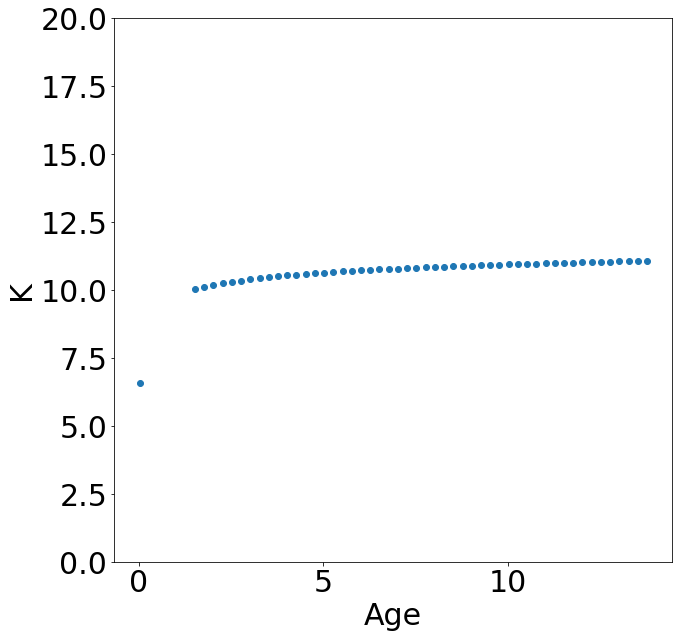

In [359]:
plt.figure(figsize=[10,10])
plt.scatter(10**uniq_ages[::10]/10**9,mags[:,2])
plt.ylim(0,20)
plt.xlabel(r'Age')
plt.ylabel(r'K')

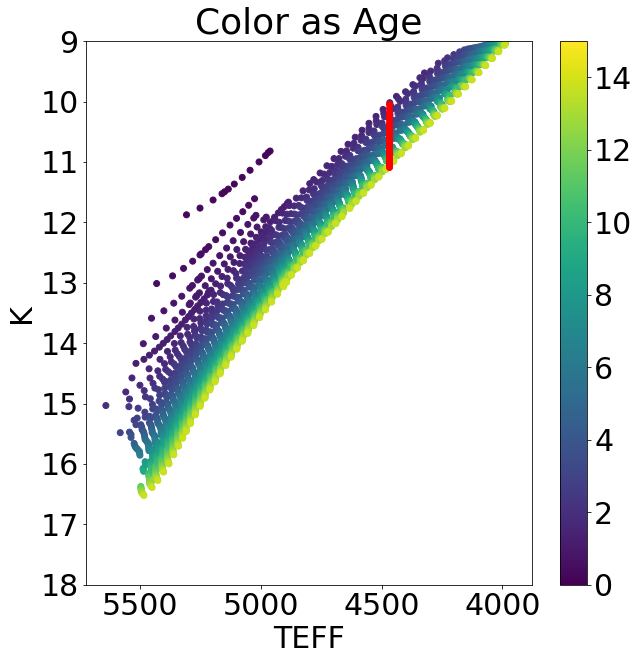

In [360]:
plt.figure(figsize=[10,10])
for i in range(len(uniq_ages[::10])):
    isopick, = np.where(CalcAge.iso['logAge']==uniq_ages[::10][i])
    iso = CalcAge.iso[isopick]

    plt.scatter(10**iso['logTe'],iso['Ksmag']+5*np.log10(10400)-5.0,c=10**iso['logAge']/10**9,vmin=0,vmax=15)

plt.colorbar()
plt.scatter(np.zeros(56)+gcs['TEFF'][1000],mags[:,2],c='r')
plt.ylim(9,18)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.title(r'Color as Age')
plt.xlabel(r'TEFF')
plt.ylabel(r'K')
plt.show()

In [361]:
mags1 = np.zeros((56,3))
CalcAge = WhatsMyAgeAgain(gcs['M_H'][1000],gcs['ALPHA_M'][1000],10400,massive)
for i in tqdm_notebook(range(len(uniq_ages))[::10]):
    mags1[int(i/10)][:] = CalcAge.Teff2AppMags(gcs['TEFF'][1000],10**uniq_ages[i]/10**9,1.)

Text(0, 0.5, 'K')

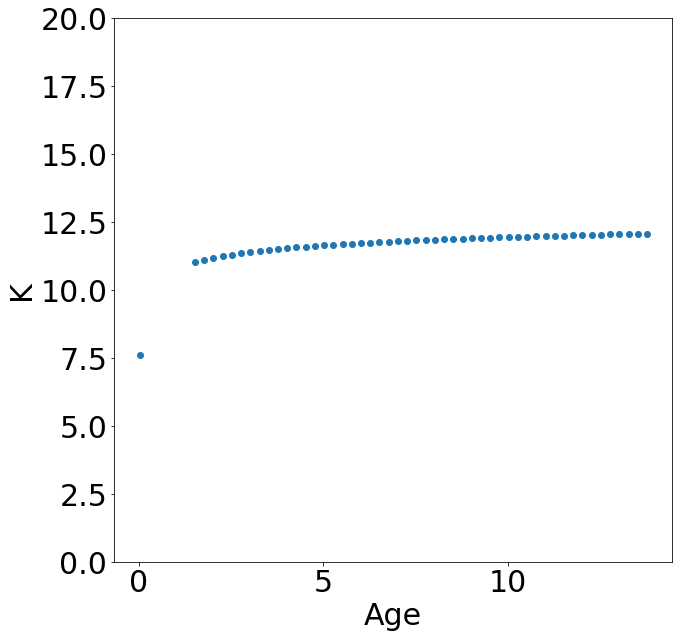

In [362]:
plt.figure(figsize=[10,10])
plt.scatter(10**uniq_ages[::10]/10**9,mags1[:,2])
plt.ylim(0,20)
plt.xlabel(r'Age')
plt.ylabel(r'K')

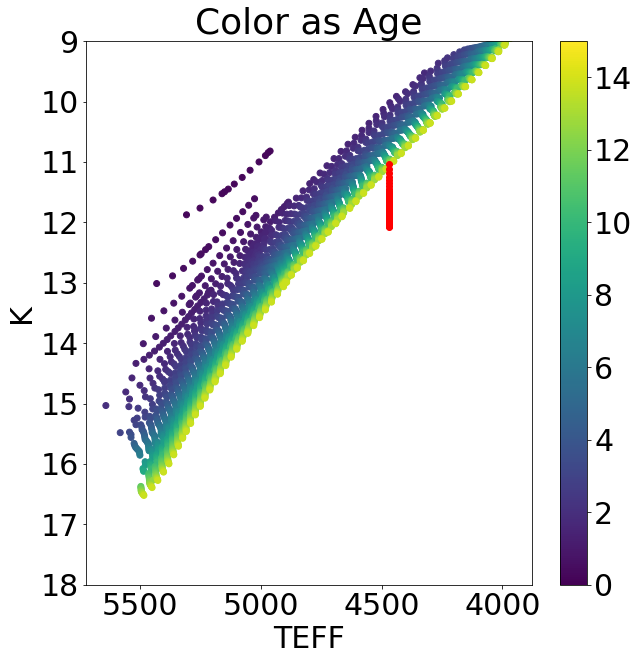

In [363]:
plt.figure(figsize=[10,10])
for i in range(len(uniq_ages[::10])):
    isopick, = np.where(CalcAge.iso['logAge']==uniq_ages[::10][i])
    iso = CalcAge.iso[isopick]

    plt.scatter(10**iso['logTe'],iso['Ksmag']+5*np.log10(10400)-5.0,c=10**iso['logAge']/10**9,vmin=0,vmax=15)

plt.colorbar()
plt.scatter(np.zeros(56)+gcs['TEFF'][1000],mags1[:,2],c='r')
plt.ylim(9,18)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.title(r'Color as Age')
plt.xlabel(r'TEFF')
plt.ylabel(r'K')
plt.show()

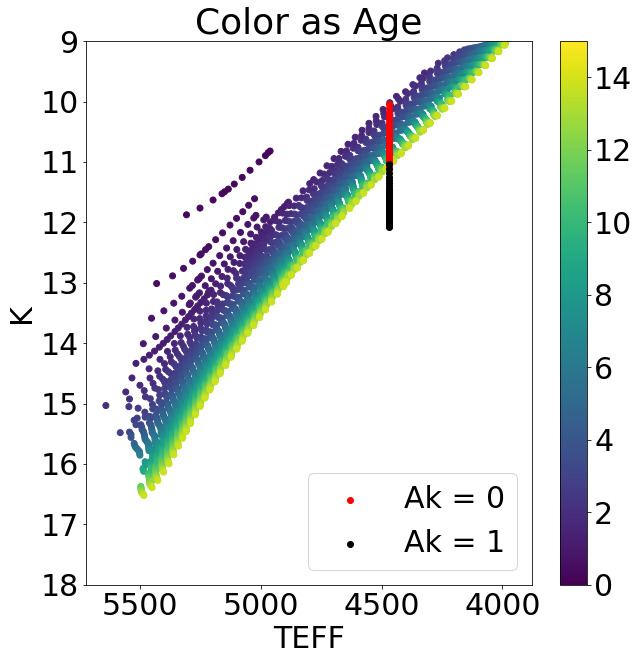

In [364]:
plt.figure(figsize=[10,10])
for i in range(len(uniq_ages[::10])):
    isopick, = np.where(CalcAge.iso['logAge']==uniq_ages[::10][i])
    iso = CalcAge.iso[isopick]

    plt.scatter(10**iso['logTe'],iso['Ksmag']+5*np.log10(10400)-5.0,c=10**iso['logAge']/10**9,vmin=0,vmax=15)

plt.colorbar()
plt.scatter(np.zeros(56)+gcs['TEFF'][1000],mags[:,2],c='r',label='Ak = 0')
plt.scatter(np.zeros(56)+gcs['TEFF'][1000],mags1[:,2],c='k',label='Ak = 1')
plt.legend()
plt.ylim(9,18)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.title(r'Color as Age')
plt.xlabel(r'TEFF')
plt.ylabel(r'K')
plt.show()

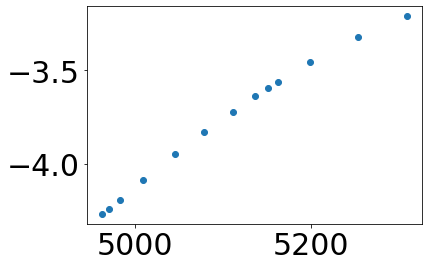

In [365]:
test = np.where(CalcAge.iso['logAge']==8.43933)
plt.scatter(10**CalcAge.iso['logTe'][test],CalcAge.iso['Ksmag'][test])

# Ages not in uniq_ages

In [366]:
print(np.median(np.diff(10**uniq_ages/10**9)))
print(np.max(10**uniq_ages/10**9))
print(np.min(10**uniq_ages/10**9))

0.02499999625598079
14.000063322395283
0.02499999950079735


In [367]:
not_uniq_ages = np.abs(np.random.normal(10**uniq_ages/10**9,1.0,560))
for i in range(len(not_uniq_ages)):
    if not_uniq_ages[i] > 14.:
        not_uniq_ages[i] -= max(not_uniq_ages)-14.0
    if not_uniq_ages[i] < 0.025:
        not_uniq_ages[i] += 0.025 - min(not_uniq_ages)
not_uniq_ages = np.log10((not_uniq_ages[np.argsort(not_uniq_ages)])*10**9)

In [368]:
not_mags = np.zeros((56,3))
CalcAge = WhatsMyAgeAgain(gcs['M_H'][1000],gcs['ALPHA_M'][1000],10400,massive)
for i in tqdm_notebook(range(len(not_uniq_ages))[::10]):
    not_mags[int(i/10)][:] = CalcAge.Teff2AppMags(gcs['TEFF'][1000],10**not_uniq_ages[i]/10**9,0)

Text(0, 0.5, 'K')

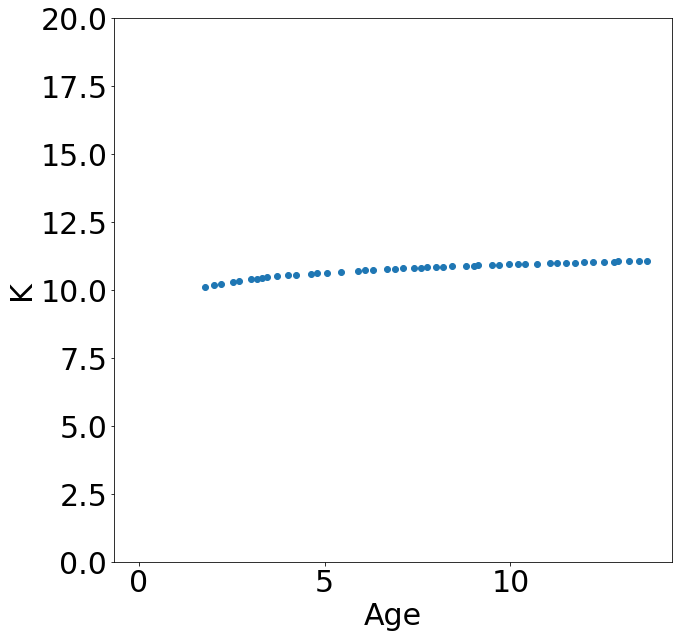

In [369]:
plt.figure(figsize=[10,10])
plt.scatter(10**not_uniq_ages[::10]/10**9,not_mags[:,2])
plt.ylim(0,20)
plt.xlabel(r'Age')
plt.ylabel(r'K')

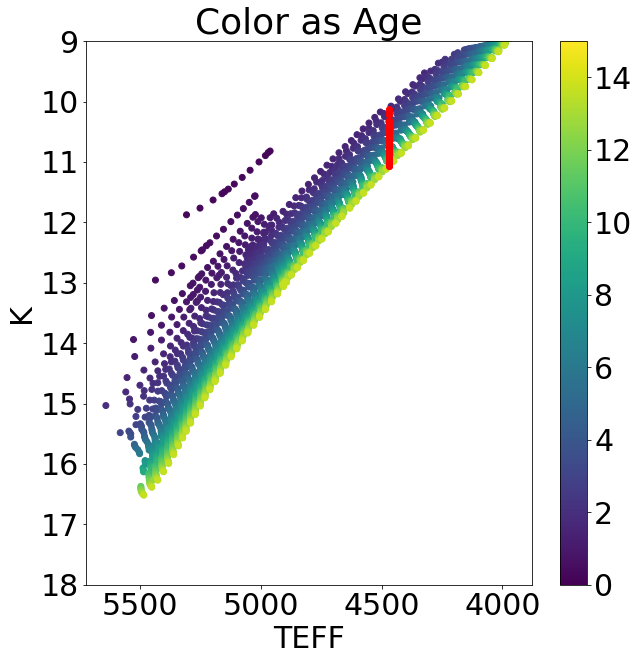

In [370]:
plt.figure(figsize=[10,10])
for i in range(len(not_uniq_ages[::10])):
    isopick, = np.where(CalcAge.iso['logAge']==closest(CalcAge.iso['logAge'],not_uniq_ages[::10][i]))
    iso = CalcAge.iso[isopick]

    plt.scatter(10**iso['logTe'],iso['Ksmag']+5*np.log10(10400)-5.0,c=10**iso['logAge']/10**9,vmin=0,vmax=15)

plt.colorbar()
plt.scatter(np.zeros(56)+gcs['TEFF'][1000],not_mags[:,2],c='r')
plt.ylim(9,18)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.title(r'Color as Age')
plt.xlabel(r'TEFF')
plt.ylabel(r'K')
plt.show()

In [371]:
not_mags1 = np.zeros((56,3))
CalcAge = WhatsMyAgeAgain(gcs['M_H'][1000],gcs['ALPHA_M'][1000],10400,massive)
for i in tqdm_notebook(range(len(not_uniq_ages))[::10]):
    not_mags1[int(i/10)][:] = CalcAge.Teff2AppMags(gcs['TEFF'][1000],10**not_uniq_ages[i]/10**9,1.)

(0.0, 20.0)

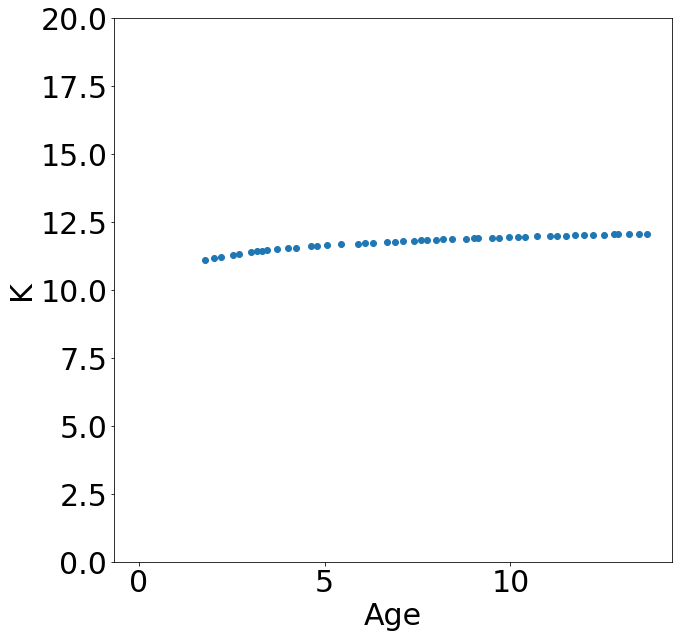

In [372]:
plt.figure(figsize=[10,10])
plt.scatter(10**not_uniq_ages[::10]/10**9,not_mags1[:,2])
plt.xlabel(r'Age')
plt.ylabel(r'K')
plt.ylim(0,20)

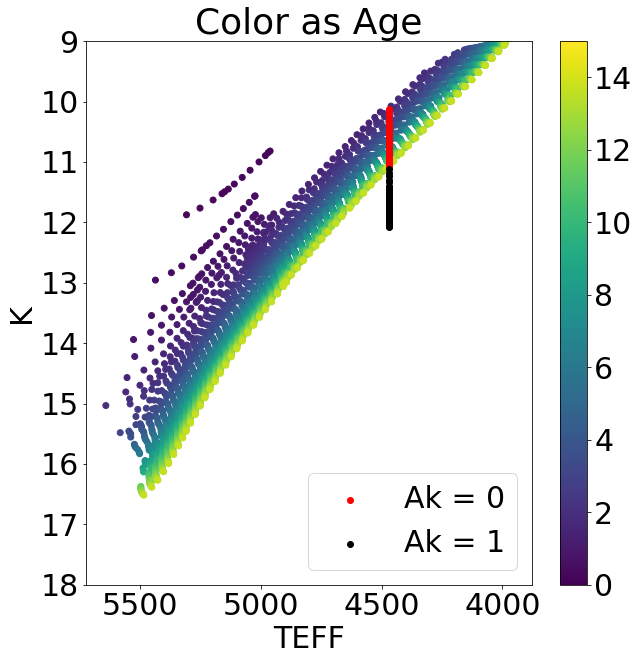

In [373]:
plt.figure(figsize=[10,10])
for i in range(len(not_uniq_ages[::10])):
    isopick, = np.where(CalcAge.iso['logAge']==closest(CalcAge.iso['logAge'],not_uniq_ages[::10][i]))
    iso = CalcAge.iso[isopick]

    plt.scatter(10**iso['logTe'],iso['Ksmag']+5*np.log10(10400)-5.0,c=10**iso['logAge']/10**9,vmin=0,vmax=15)

plt.colorbar()
plt.scatter(np.zeros(56)+gcs['TEFF'][1000],not_mags[:,2],c='r',label='Ak = 0')
plt.scatter(np.zeros(56)+gcs['TEFF'][1000],not_mags1[:,2],c='k',label='Ak = 1')
plt.legend()
plt.ylim(9,18)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.title(r'Color as Age')
plt.xlabel(r'TEFF')
plt.ylabel(r'K')
plt.show()

# curve_fit Test

In [374]:
from scipy.optimize import curve_fit

#[CalcAge.InitialAge(gcs['TEFF'][idx],gcs['K'][idx],gcs['AK_TARG'][idx]),
#                           gcs['AK_TARG'][idx]]

p0 = [1.0,0.5]

idx = 1024
CalcAge = WhatsMyAgeAgain(gcs['M_H'][idx],gcs['ALPHA_M'][idx],10400,massive)
CalcAge.InitialAge(gcs['TEFF'][idx],gcs['K'][idx],gcs['AK_TARG'][idx])

popt,pcov = curve_fit(CalcAge.Teff2AppMags,gcs['TEFF'][idx],
                      np.array([[gcs['J'][idx],gcs['H'][idx],gcs['K'][idx]]],dtype=float).T.ravel(),
                      p0=p0,bounds=((0.,0.),(14.,2.)),method='trf')

# print('Initial Age',CalcAge.InitialAge(gcs['TEFF'][idx],gcs['K'][idx],gcs['AK_TARG'][idx]))
# print('AK_TARG',gcs['AK_TARG'][idx])
print('Initial',p0)
print('Age; Ak',popt)
print(pcov)

Initial [1.0, 0.5]
Age; Ak [1.  0.5]
[[0. 0.]
 [0. 0.]]


In [2]:
ages0 = np.arange(0,14)
aks0 = [0,0.5,1.0]

initial_age = np.array([])
initial_aks = np.array([])

# chi = 999999.0*np.ones((len(ages0),len(aks0)))
chi = []

idx = 1024
CalcAge = WhatsMyAgeAgain(gcs['M_H'][idx],gcs['ALPHA_M'][idx],10400,massive)
age = []
ak = []
cmags = []

for i in tqdm_notebook(range(len(ages0))):
    for j in range(len(aks0)):
        
        popt,pcov = curve_fit(CalcAge.Teff2AppMags,gcs['TEFF'][idx],
                      np.array([[gcs['J'][idx],gcs['H'][idx],gcs['K'][idx]]],dtype=float).T.ravel(),
                      p0=[ages0[i],aks0[j]],bounds=((0.,0.),(14.,2.)),method='trf',
                          sigma=[gcs['J_ERR'][idx],gcs['H_ERR'][idx],gcs['K_ERR'][idx]])
    
        age.append(popt[0])
        ak.append(popt[1])
        
        initial_age = np.append(initial_age,ages0[i])
        initial_aks = np.append(initial_aks,aks0[j])
        
        calc_mags = np.asarray(CalcAge.Teff2AppMags(gcs['TEFF'][idx],popt[0],popt[1]))
        cmags.append(calc_mags)
        
        mag_errs = np.array([gcs['J_ERR'][idx],gcs['H_ERR'][idx],gcs['K_ERR'][idx]])
        mags = np.array([gcs['J'][idx],gcs['H'][idx],gcs['K'][idx]])
    
        chi1 = sum((calc_mags-mags)**2/mag_errs**2)
        print(chi1)
        
        chi.append(chi1)
    
bestind = np.asarray(chi).argmin()
bestchi = np.min(chi)  
bestage = age[bestind] 
bestak = ak[bestind]
# bestmag = cmags[bestind]

print('chi',bestchi)
print('Age',bestage)
print('Ak',bestak)

NameError: name 'np' is not defined

In [435]:
### GCs distances in pc
harris = np.array([4.5,4.4,6.4,4.8,7.1,8.8,11.5,3.2,10.2,2.2,7.5,17.9,26.5,5.4,4.0,12.9,12.1,9.6,8.9,4.9,
                   8.6,2.3,4.0,5.2])*1000.

gcs_dist = 999999.0*np.ones(len(gcs))
for i in range(len(np.unique(gcs['CLUSTER']))):
    clus = np.where(gcs['CLUSTER']==np.unique(gcs['CLUSTER'])[i])
    gcs_dist[clus] = harris[i]

### Run 2MASS code
guess_ages = np.arange(0,14)
guess_aks = [0,0.5,1.0]

best_ages = 999999.0*np.ones(len(gcs))
best_chis = 999999.0*np.ones(len(gcs))
best_aks = 999999.0*np.ones(len(gcs))

for i in tqdm_notebook(range(len(gcs))):
    curve_ages = []
    curve_aks = []
    curve_chi = []
    
    CalcAge = WhatsMyAgeAgain(gcs['M_H'][i],gcs['ALPHA_M'][i],gcs_dist[i],massive)
    for j in range(len(guess_ages)):
        for k in range(len(guess_aks)):
            try:
                popt,_ = curve_fit(CalcAge.Teff2AppMags,gcs['TEFF'][i],
                                   np.array([[gcs['J'][i],gcs['H'][i],gcs['K'][i]]],dtype=float).T.ravel(),
                                   p0=[ages0[j],aks0[k]],bounds=((0.,0.),(14.,2.)),method='trf',
                                   sigma=[gcs['J_ERR'][i],gcs['H_ERR'][i],gcs['K_ERR'][i]],maxfev=5000)
            
                curve_ages.append(popt[0])
                curve_aks.append(popt[1])
                curve_mags = np.asarray(CalcAge.Teff2AppMags(gcs['TEFF'][i],popt[0],popt[1]))
            
                obs_mags = np.array([gcs['J'][i],gcs['H'][i],gcs['K'][i]])
                obs_mags_err = np.array([gcs['J_ERR'][i],gcs['H_ERR'][i],gcs['K_ERR'][i]])
            
                curve_chi.append(sum((curve_mags-obs_mags)**2/obs_mags_err**2))
            
            except:
                print([i,j,k])
                curve_ages.append(999999.0)
                curve_aks.append(999999.0)
                curve_mags = np.array([999999.0,999999.0,999999.0])
                
                obs_mags = np.array([gcs['J'][i],gcs['H'][i],gcs['K'][i]])
                obs_mags_err = np.array([gcs['J_ERR'][i],gcs['H_ERR'][i],gcs['K_ERR'][i]])
                curve_chi.append(999999.0)
                
    best_idx = np.asarray(curve_chi).argmin()
    best_chis[i] = np.min(curve_chi)
    best_ages[i] = np.asarray(curve_ages)[best_idx]
    best_aks[i] = np.asarray(curve_aks)[best_idx]

[435, 7, 1]
[992, 7, 1]
[1083, 3, 2]
[1087, 9, 1]



In [447]:
best_aks

array([0.05184383, 0.00280817, 0.00296117, ..., 0.00763667, 0.02425466,
       0.06201869])

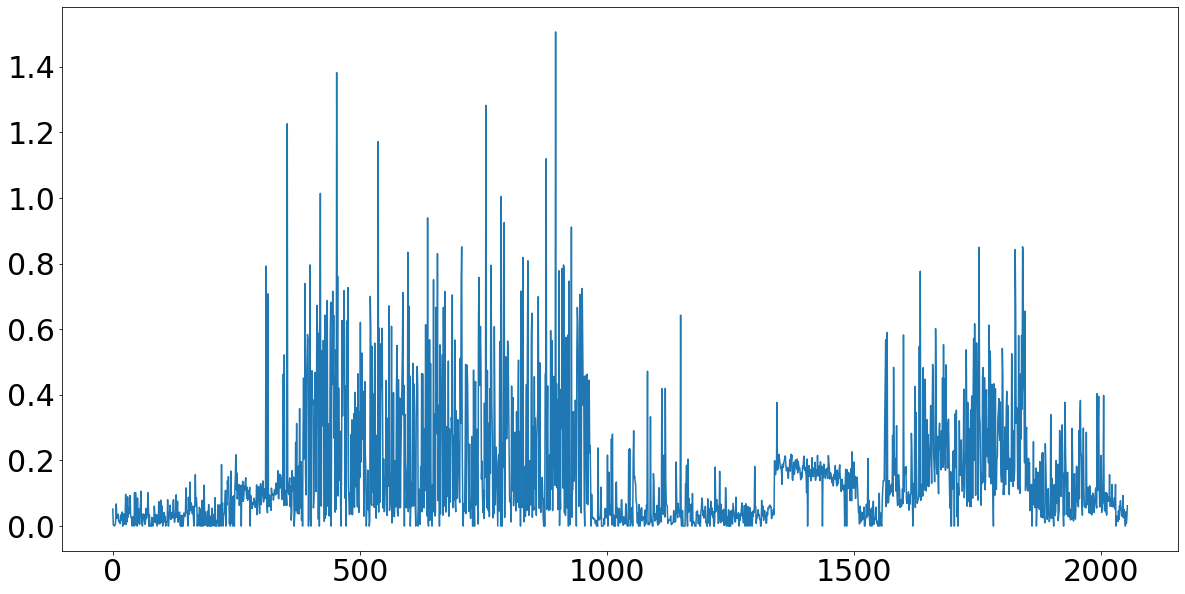

In [464]:
plt.figure(figsize=[20,10])
plt.plot(best_aks)
plt.show()

In [480]:
# LMC
lmc = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.r13-l33-58672.fits.gz')
cln = np.where((lmc['FE_H']>-9999.0)&(lmc['AK_TARG']>-100.0)&(lmc['LOGG']>=0.0)&
                (lmc['M_H_ERR']>-100.0)&(lmc['C_FE']>-100.0)&(lmc['N_FE']>-100.0))
lmc = lmc[cln]

print(min(lmc['LOGG']))
print(max(lmc['LOGG']))

3.5826117e-05
2.984853


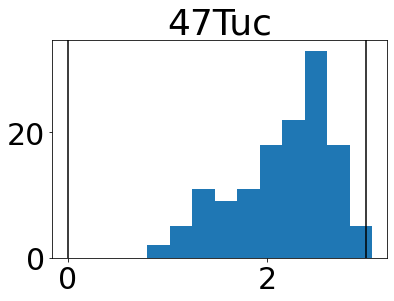

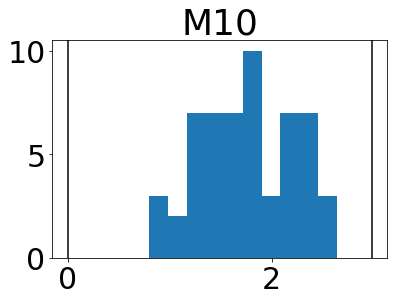

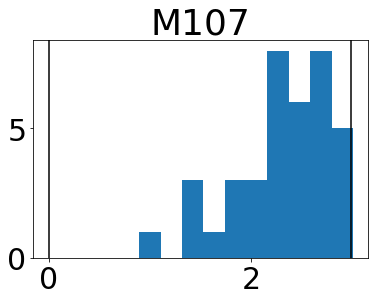

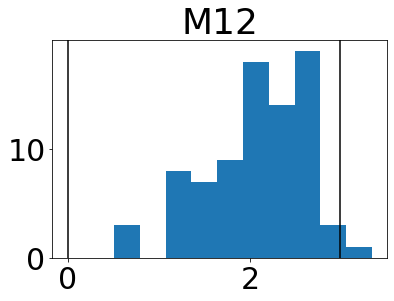

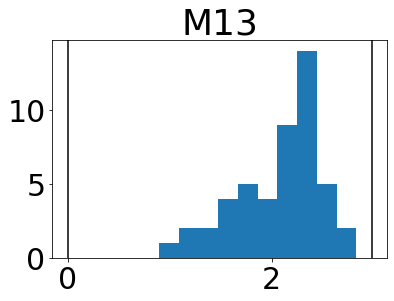

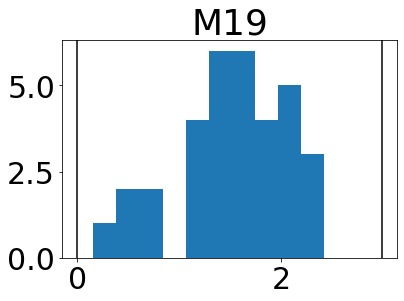

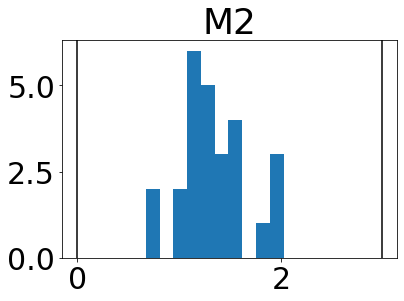

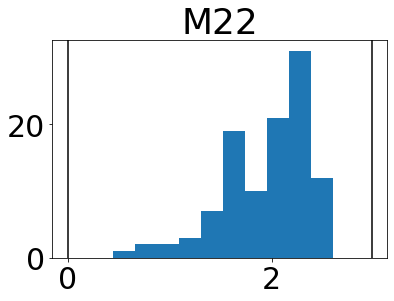

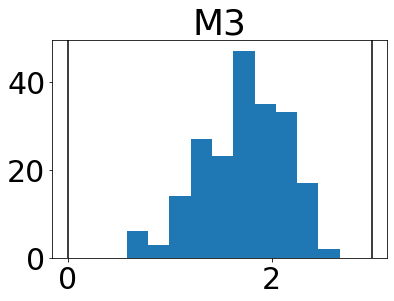

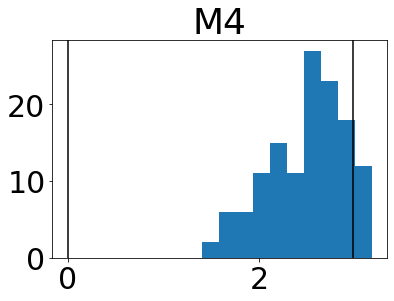

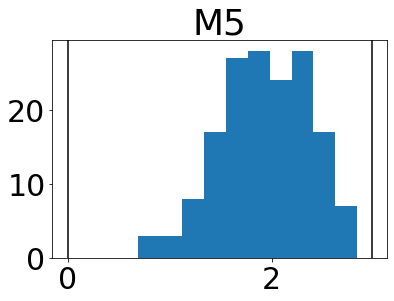

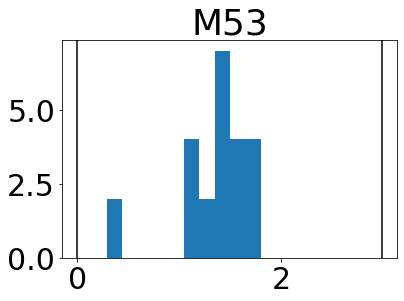

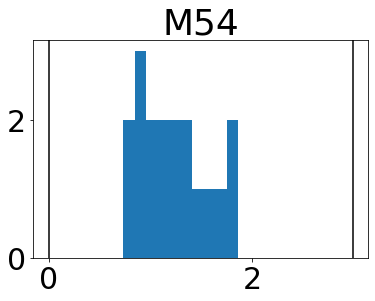

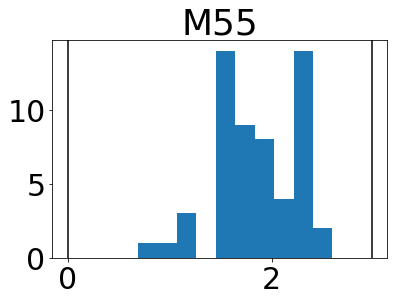

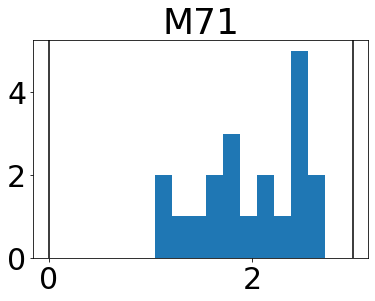

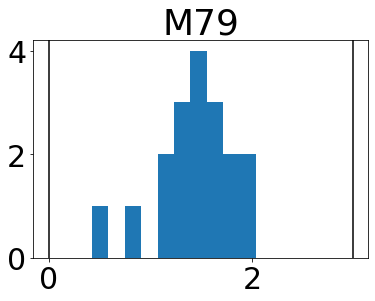

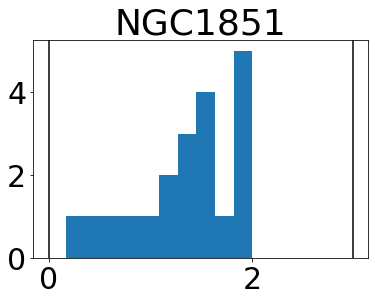

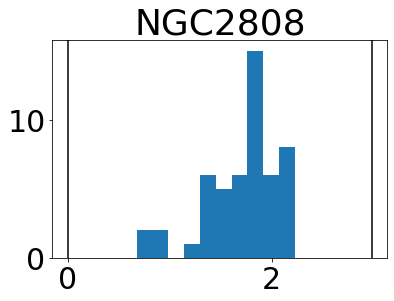

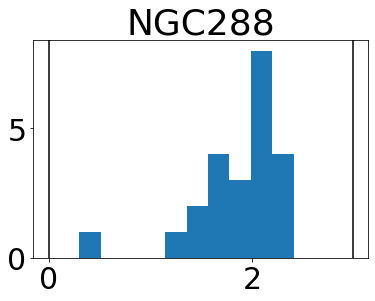

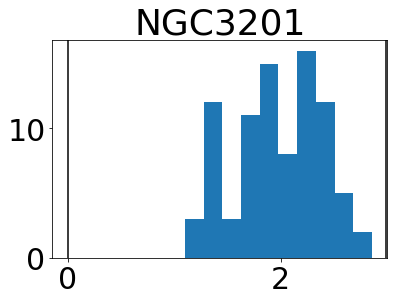

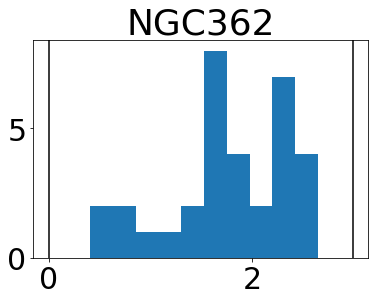

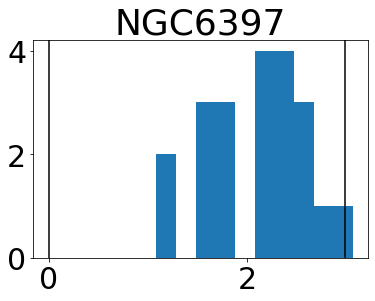

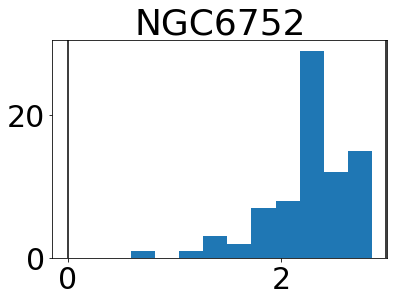

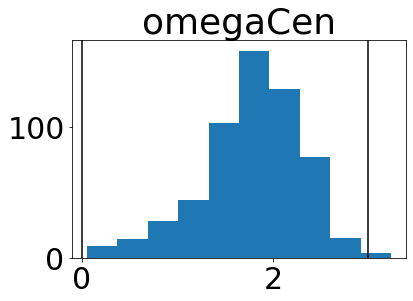

In [481]:
for i in range(len(gcs_clus)):
    clus = np.where(gcs['CLUSTER']==gcs_clus[i])
    plt.figure()
    plt.hist(gcs[clus]['LOGG'])
    plt.axvline(3.5826117e-05,c='k')
    plt.axvline(2.984853,c='k')
    plt.title(r'{}'.format(gcs_clus[i]))
    plt.show()

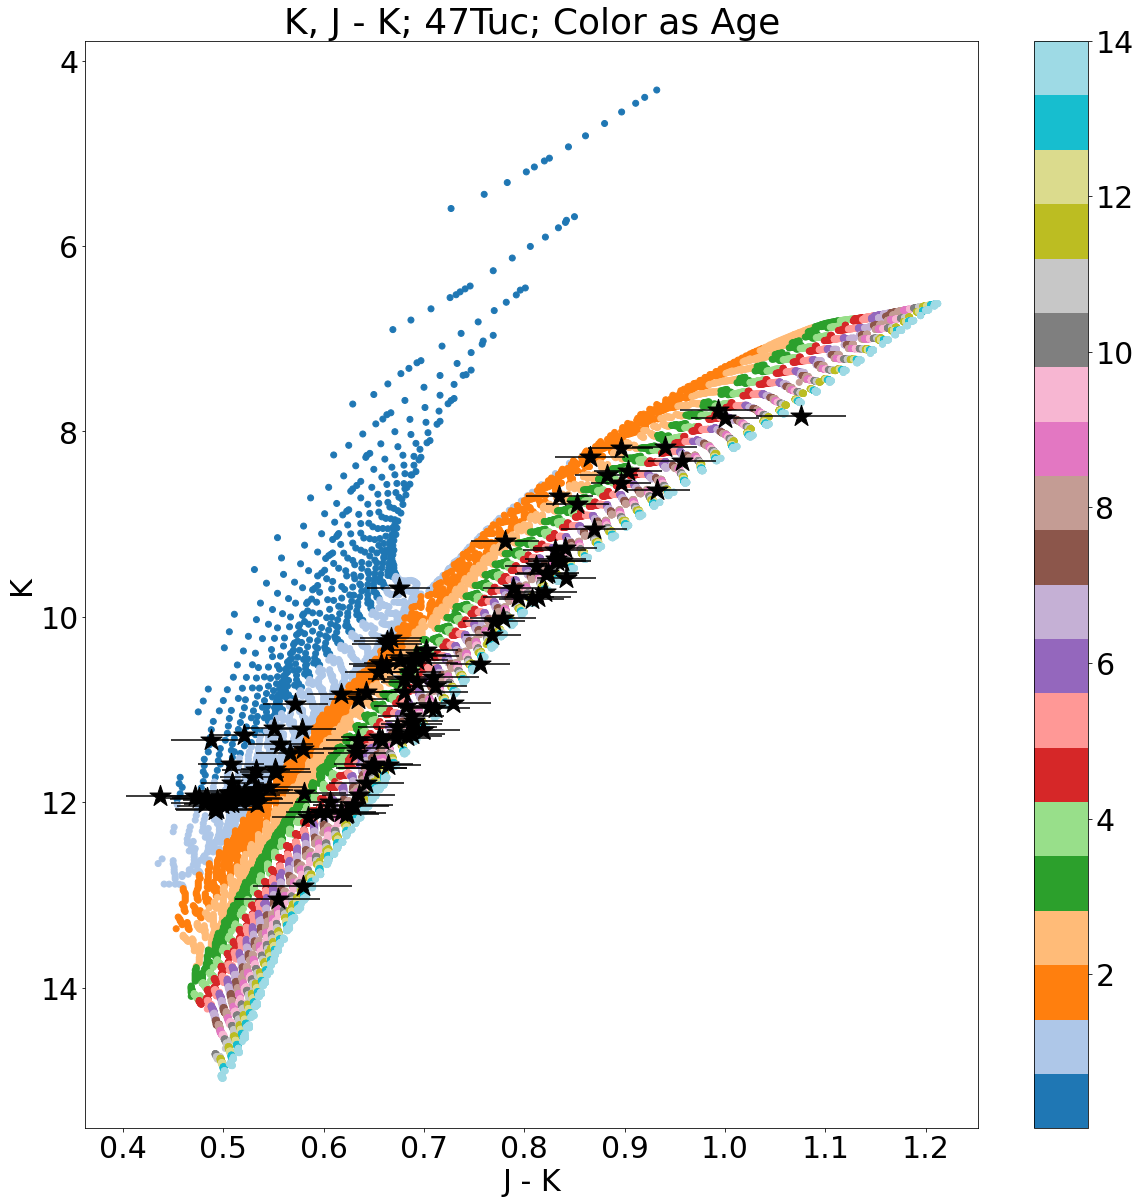

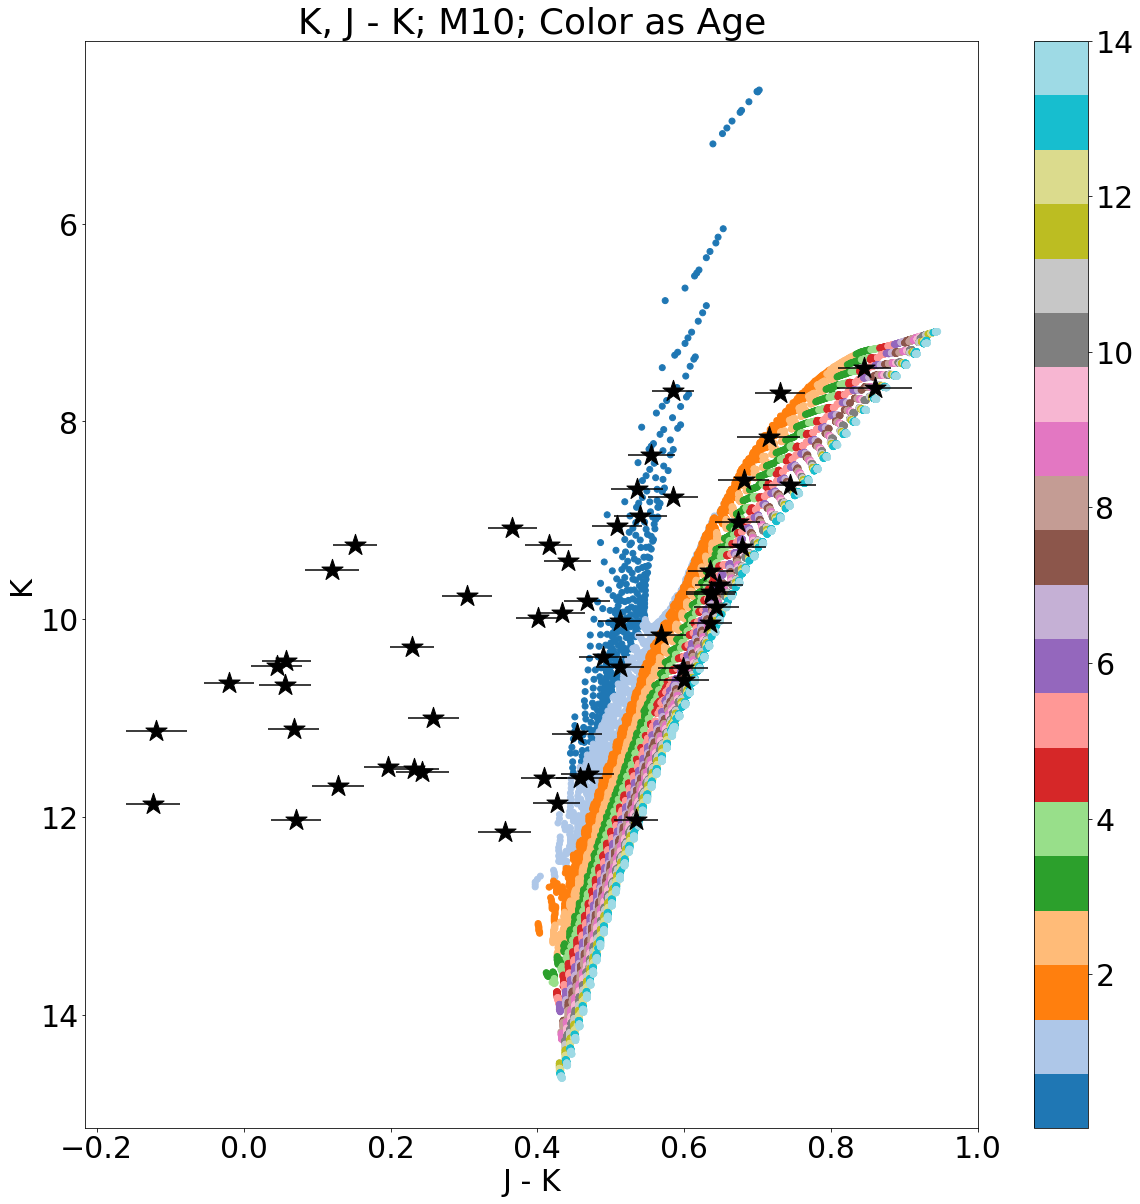

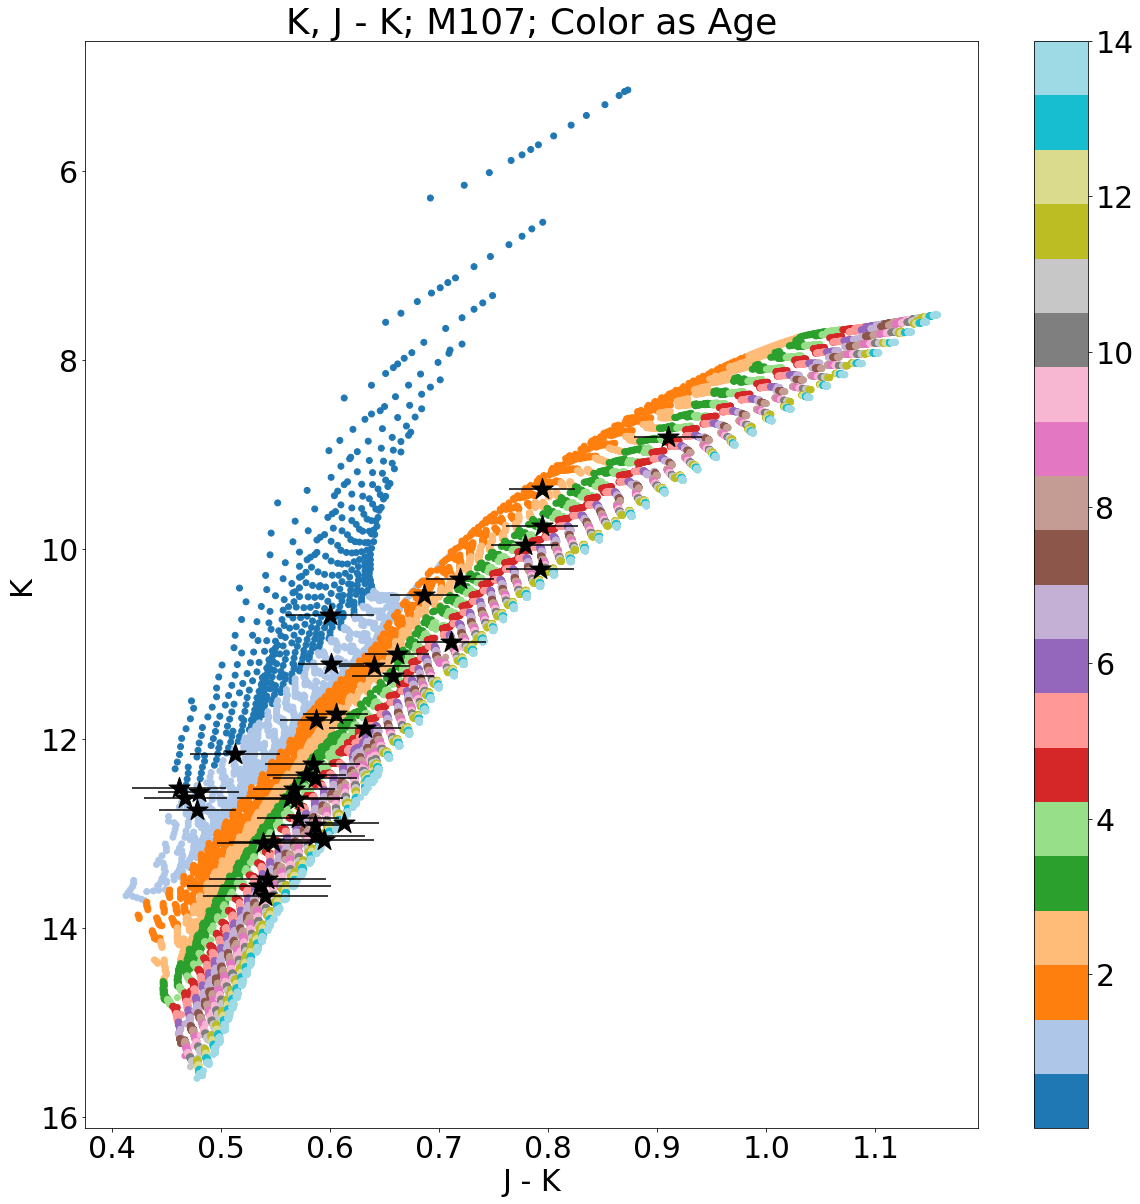

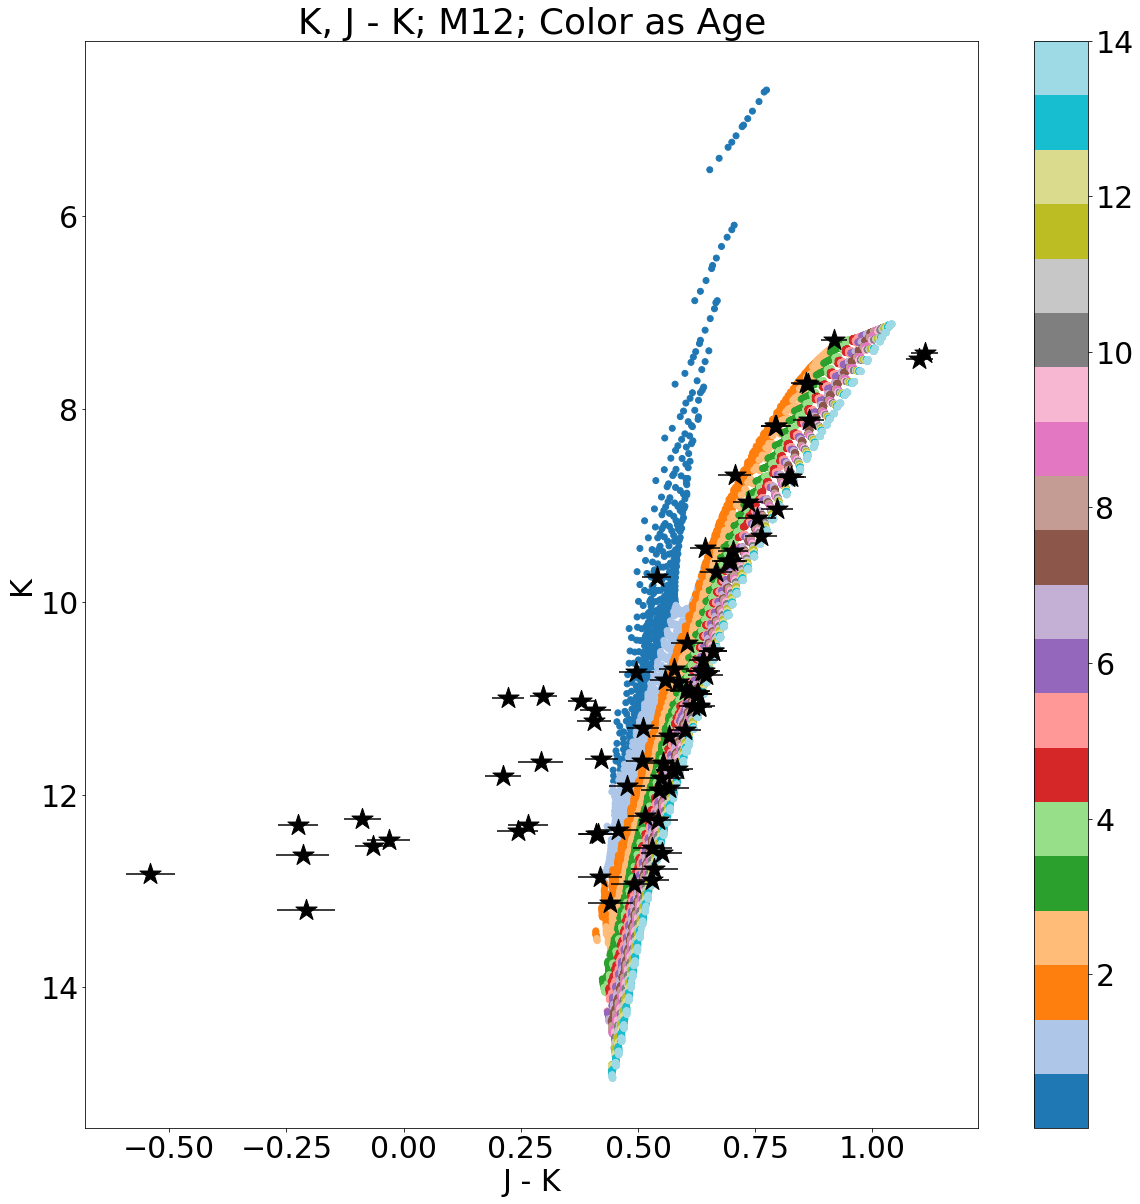

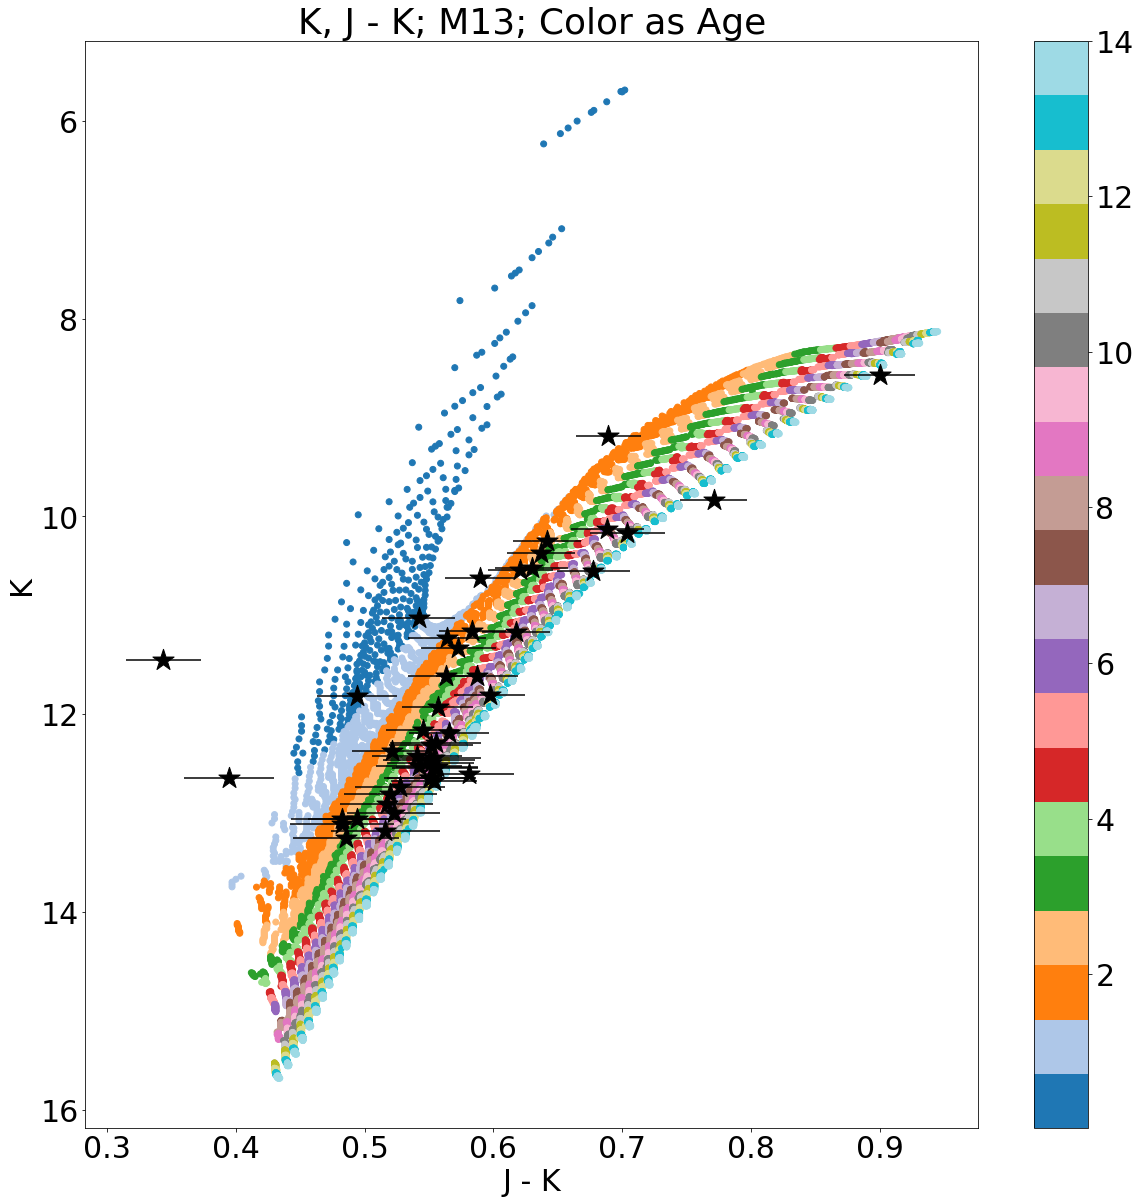

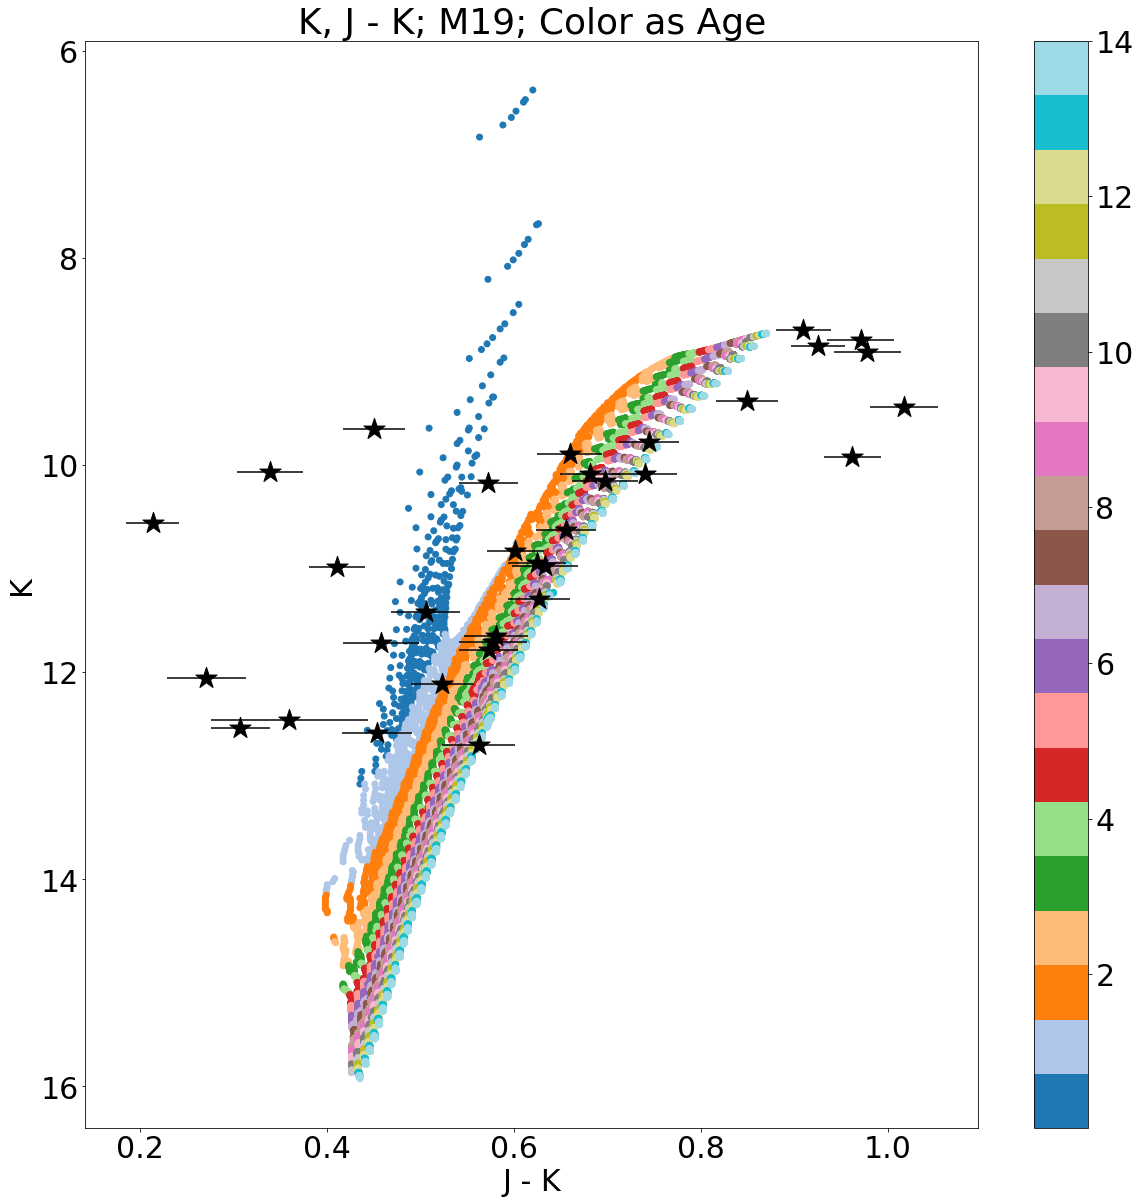

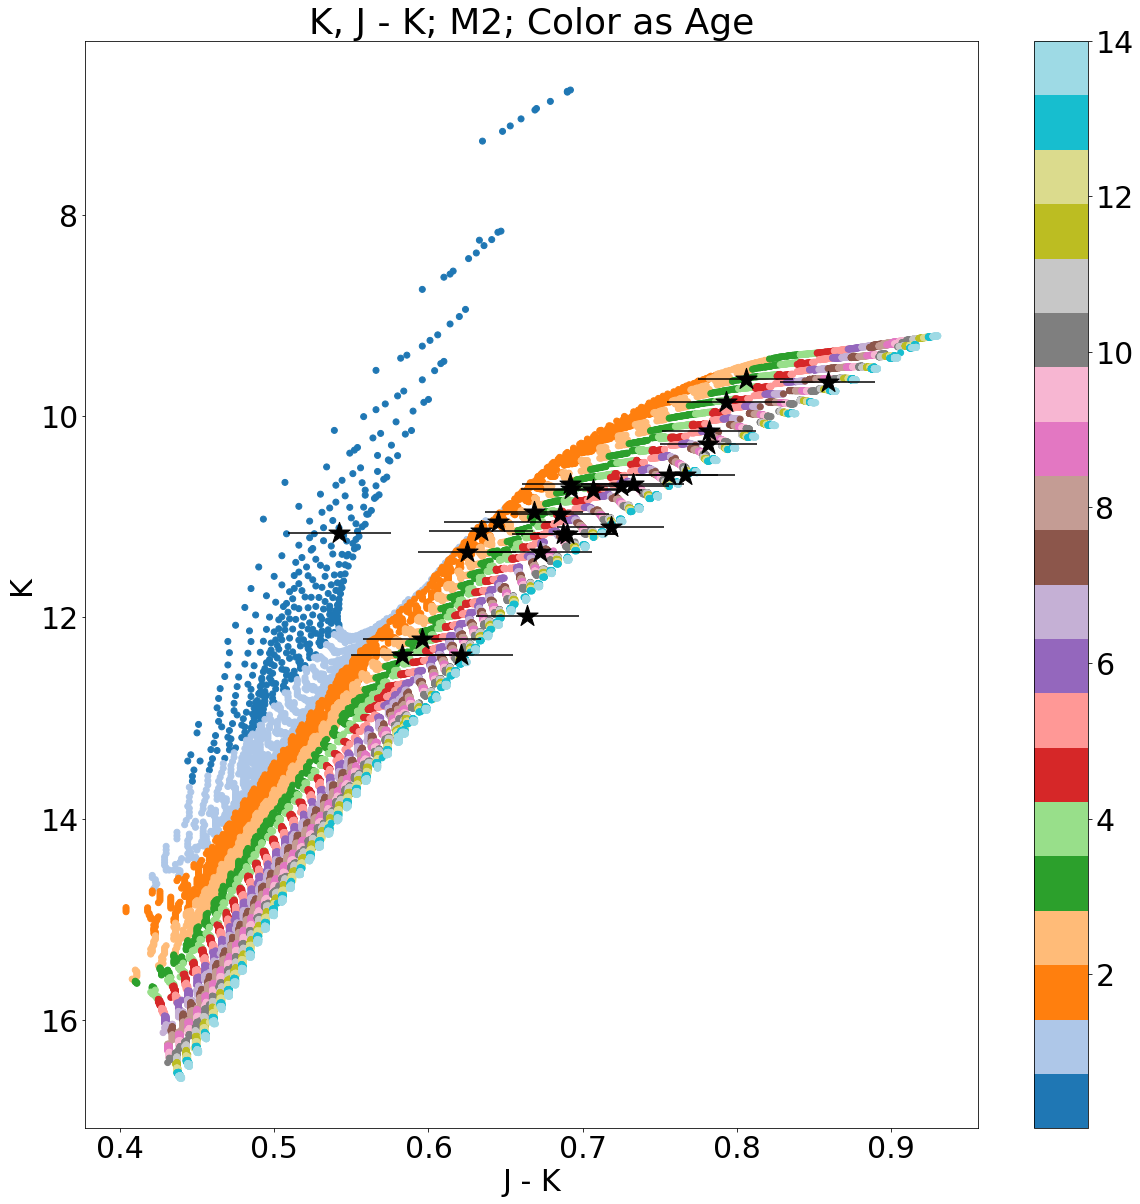

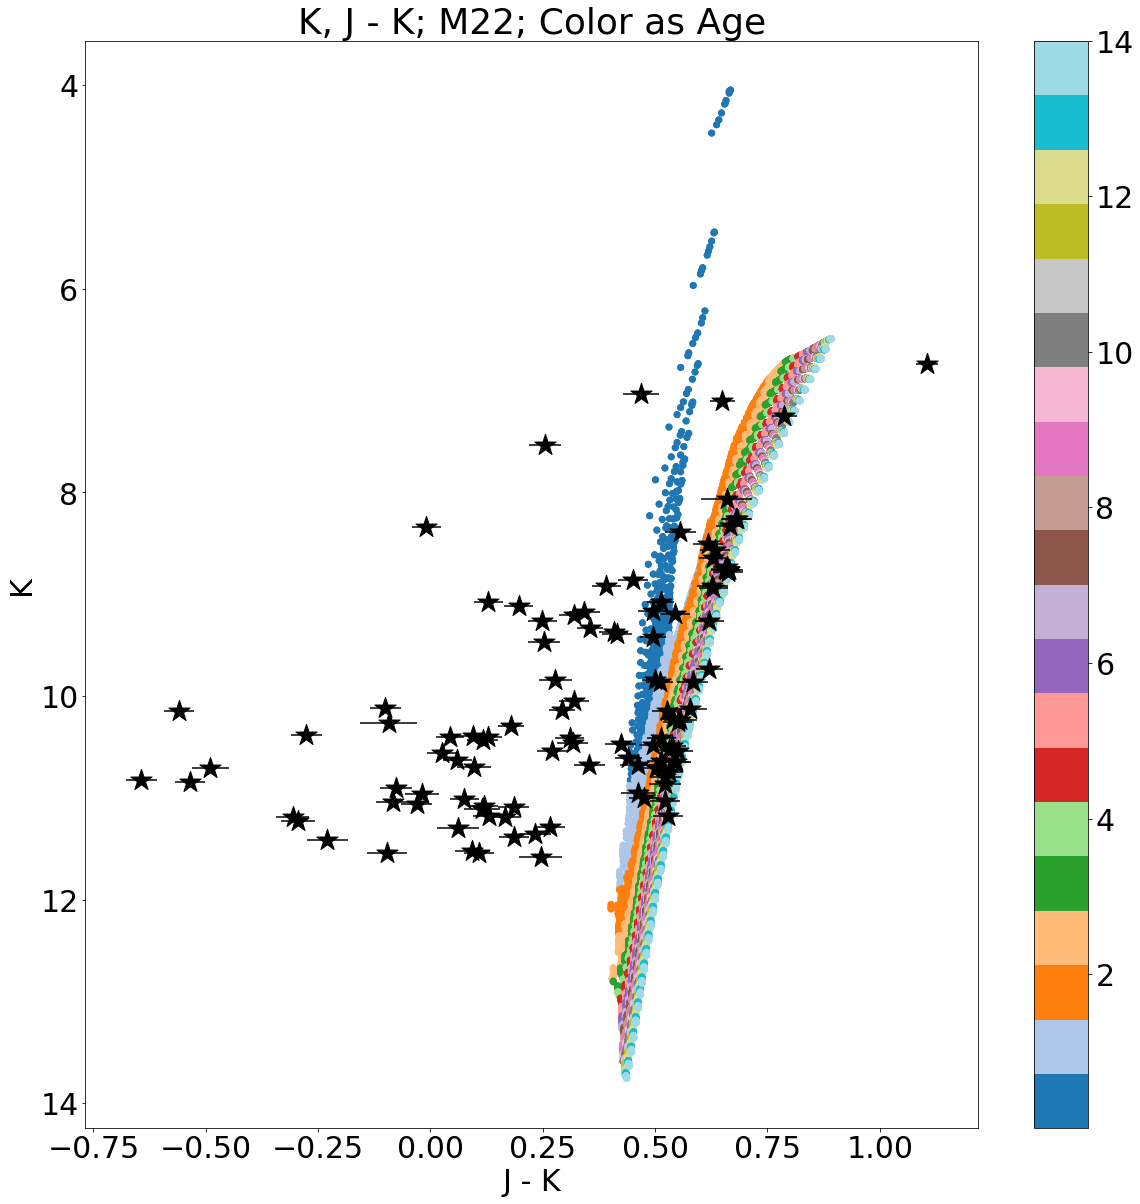

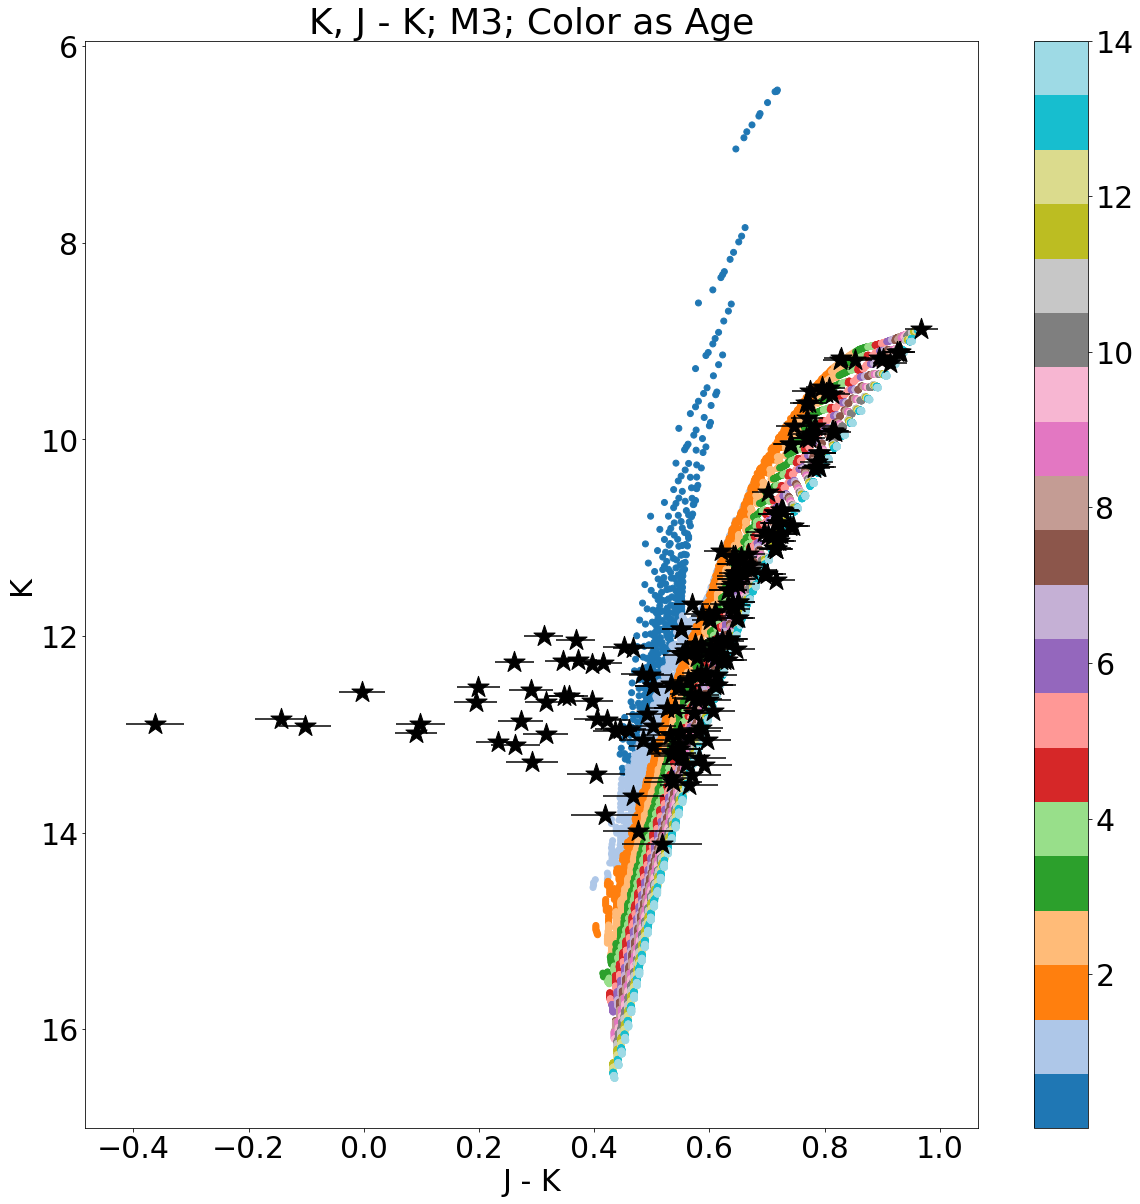

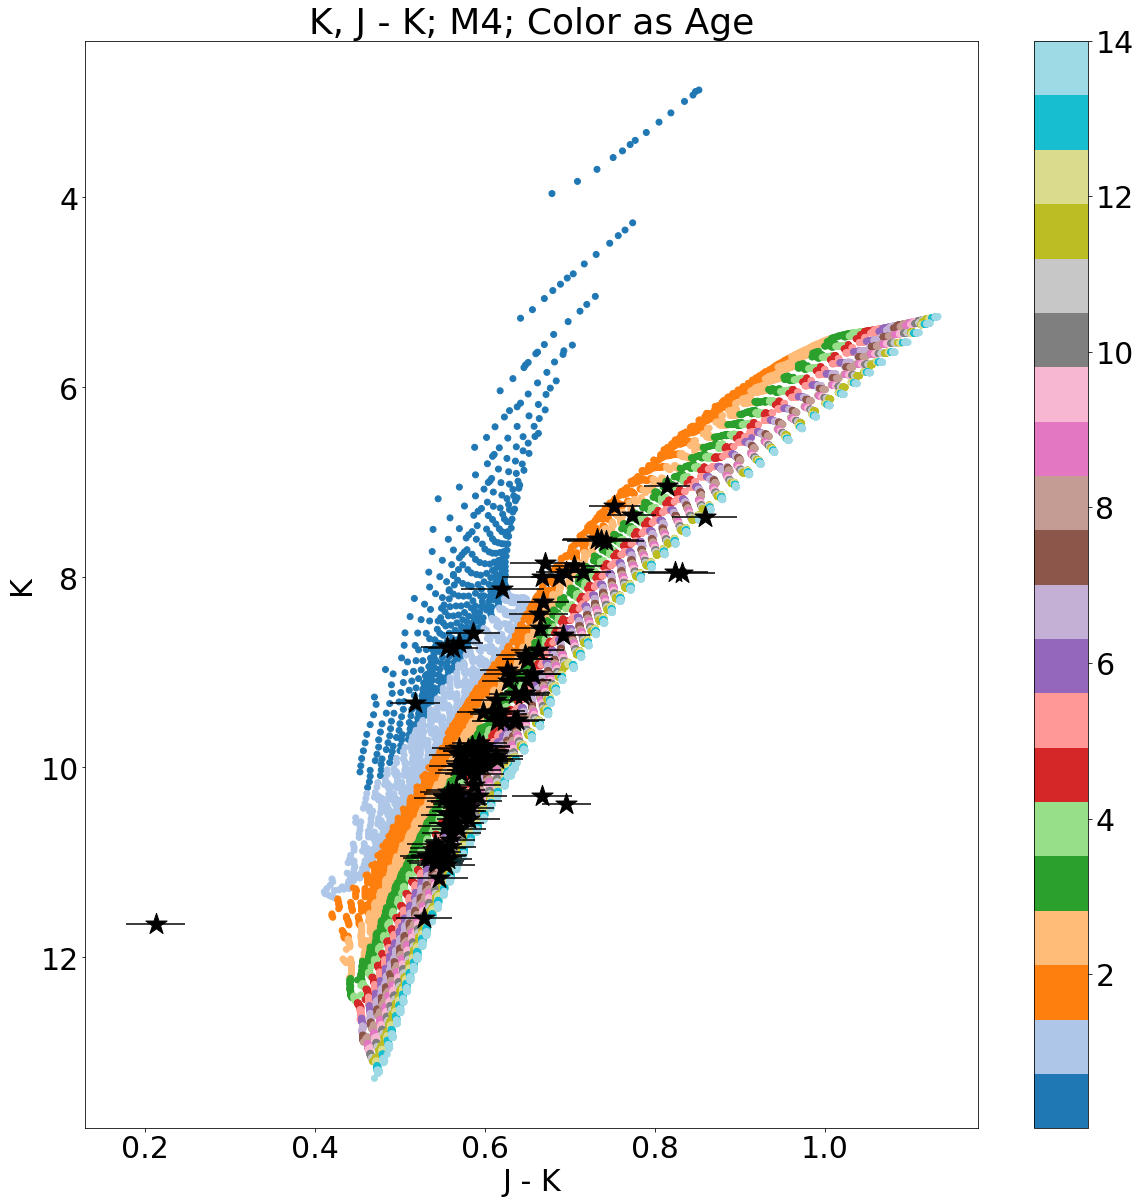

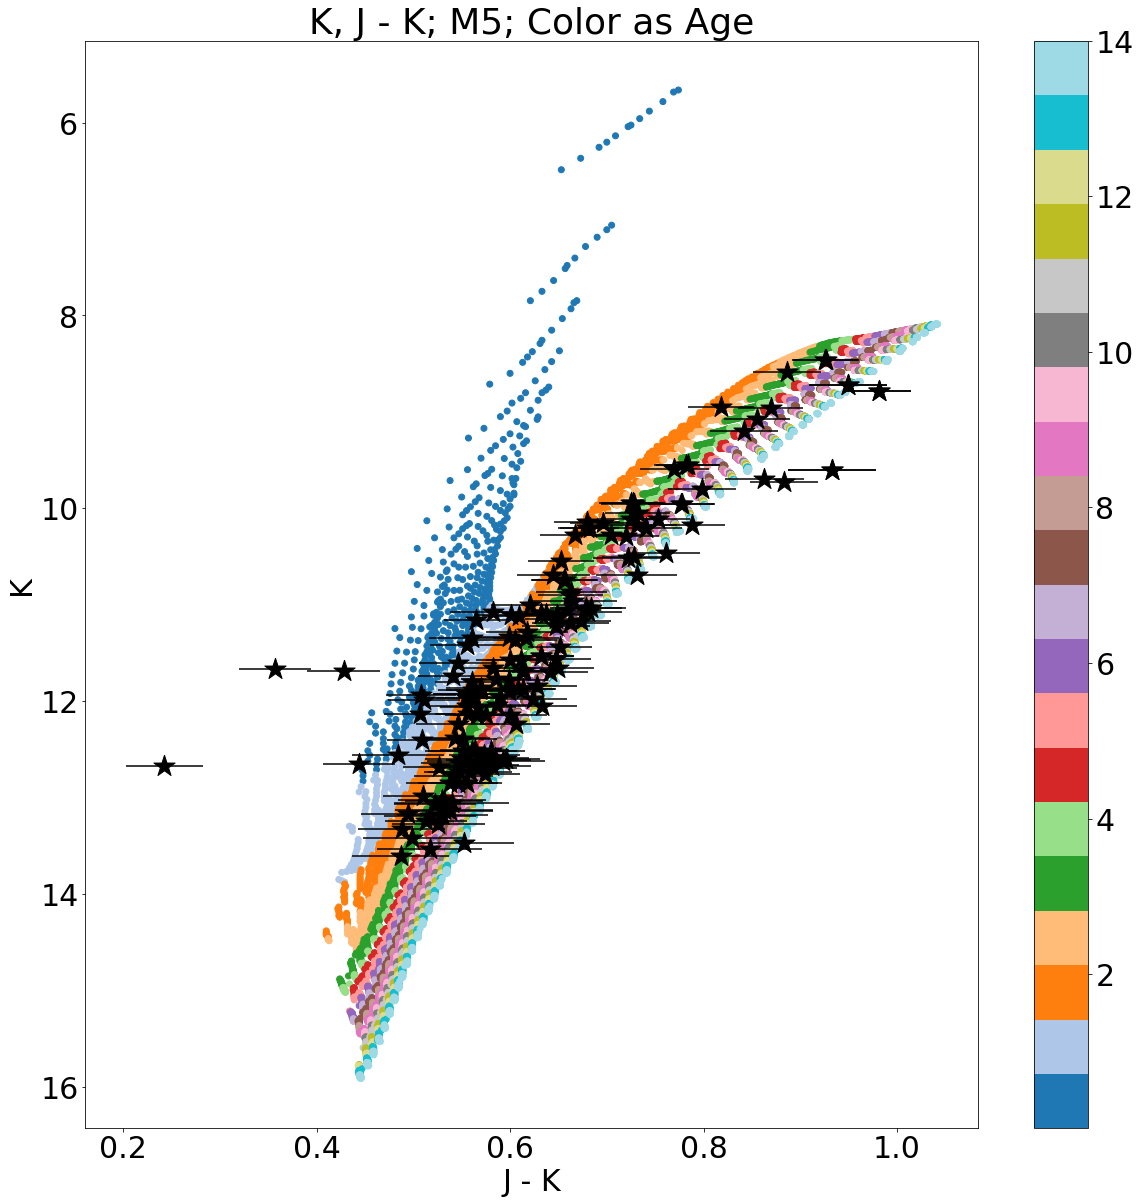

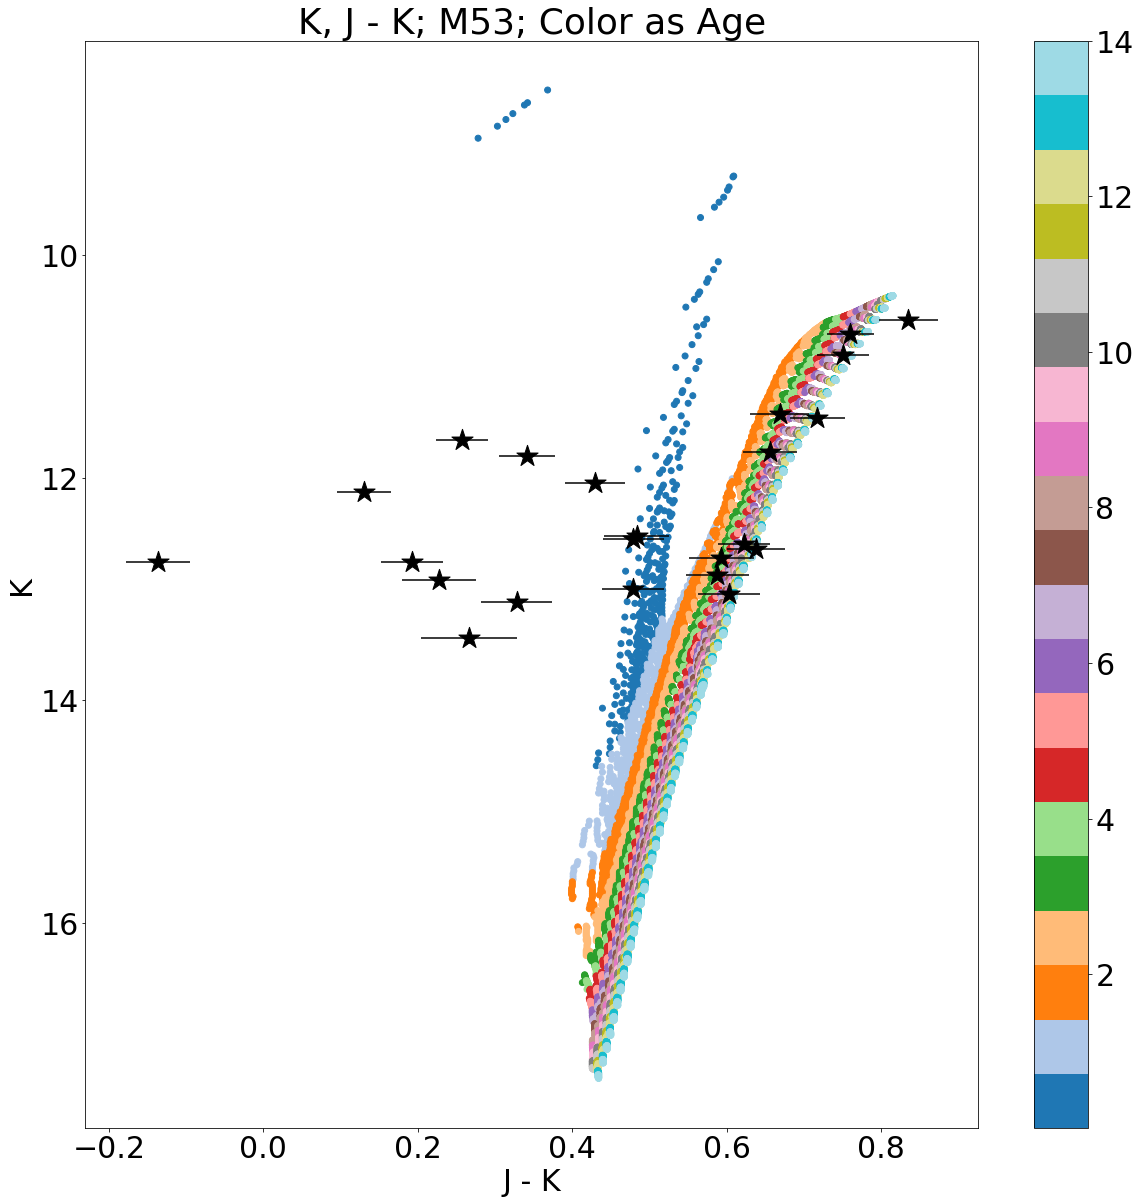

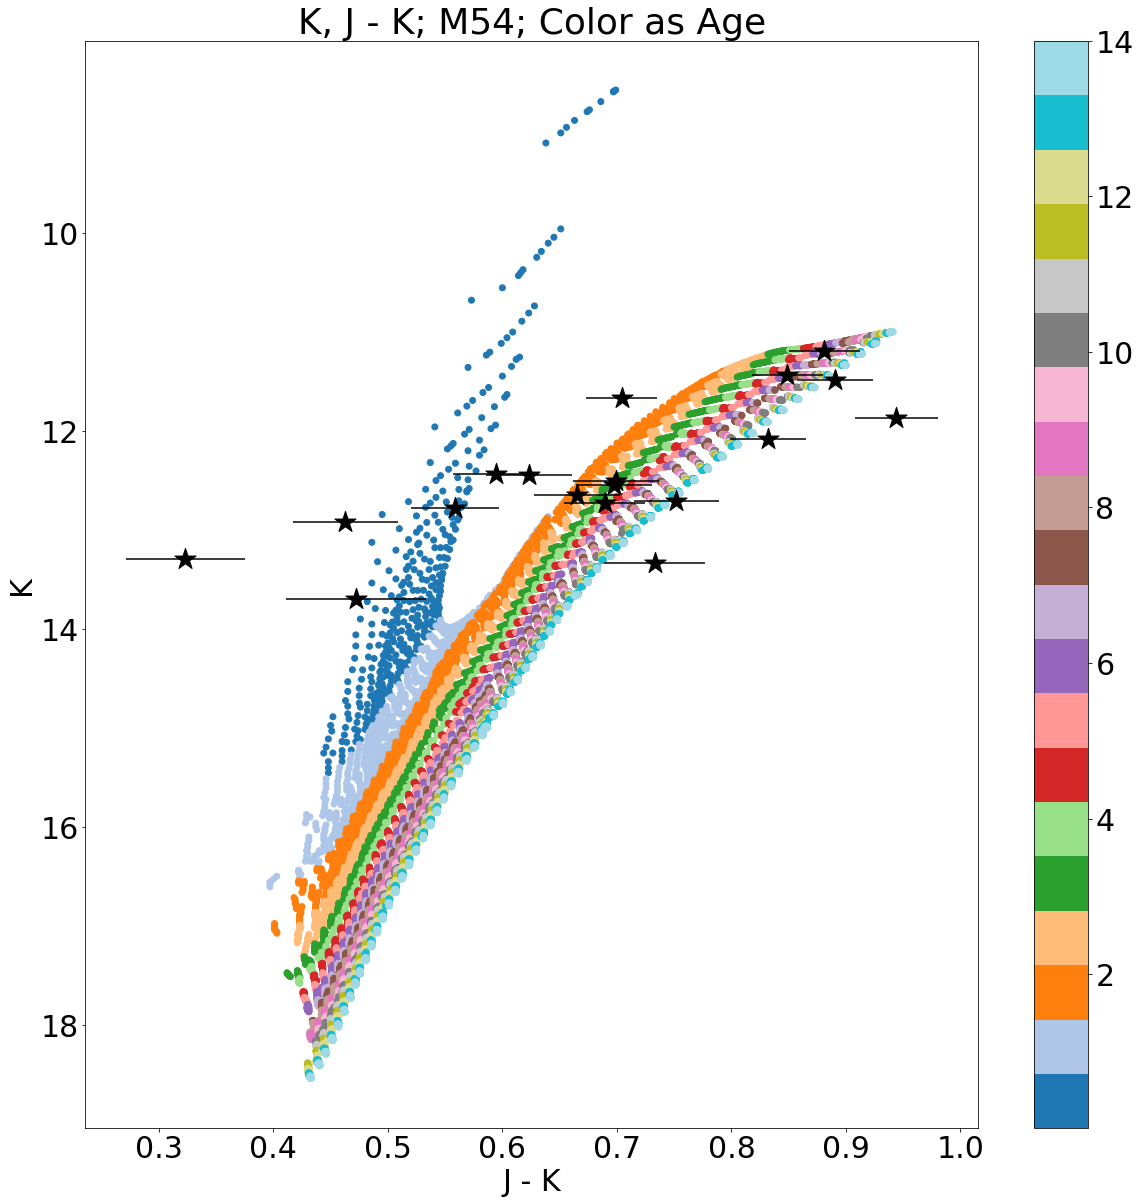

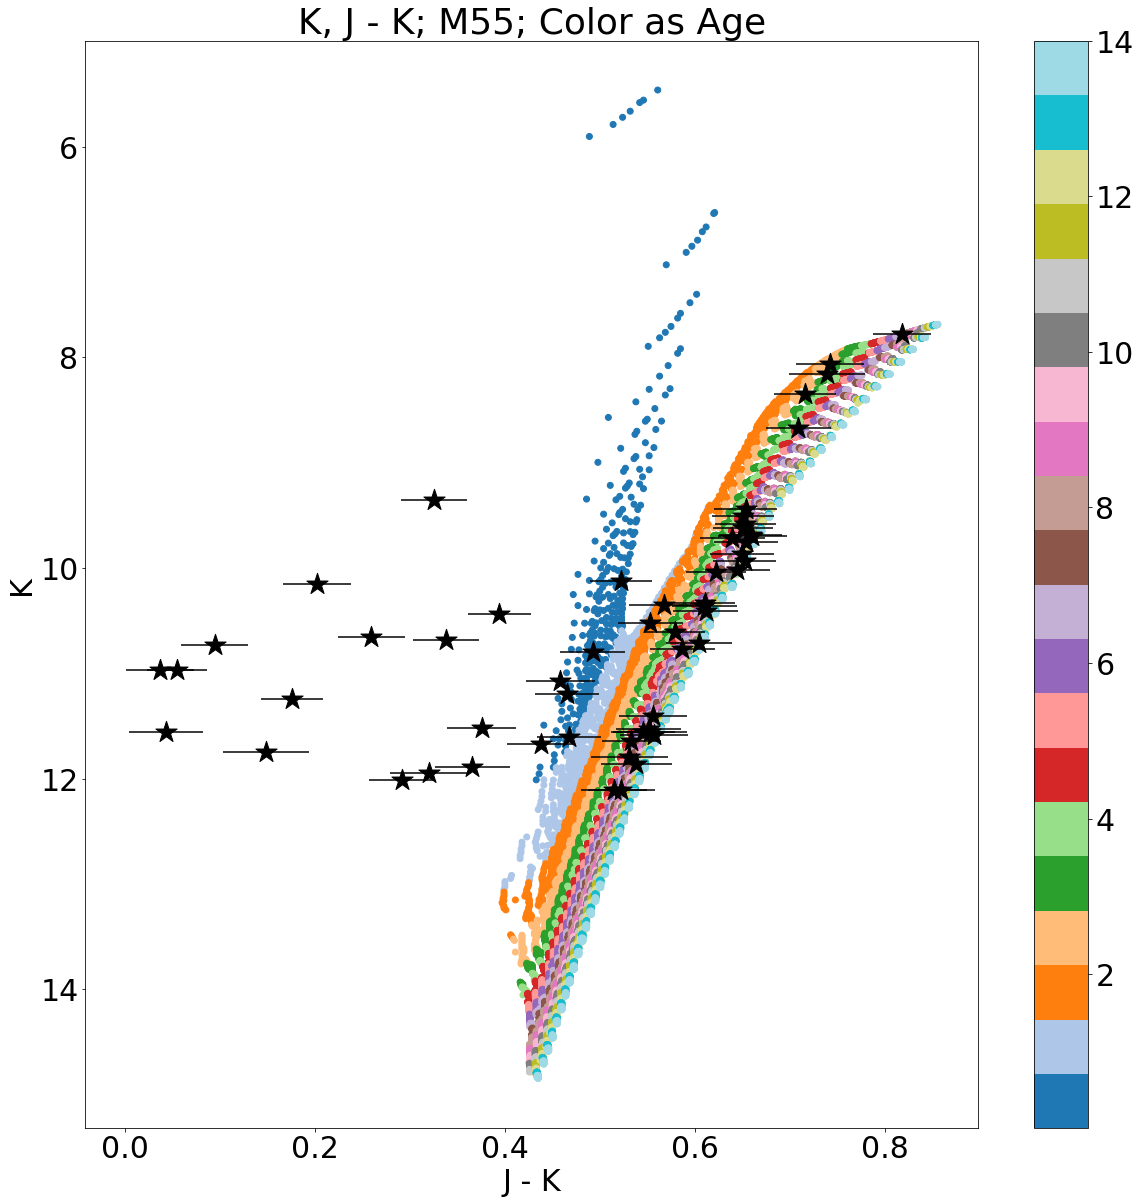

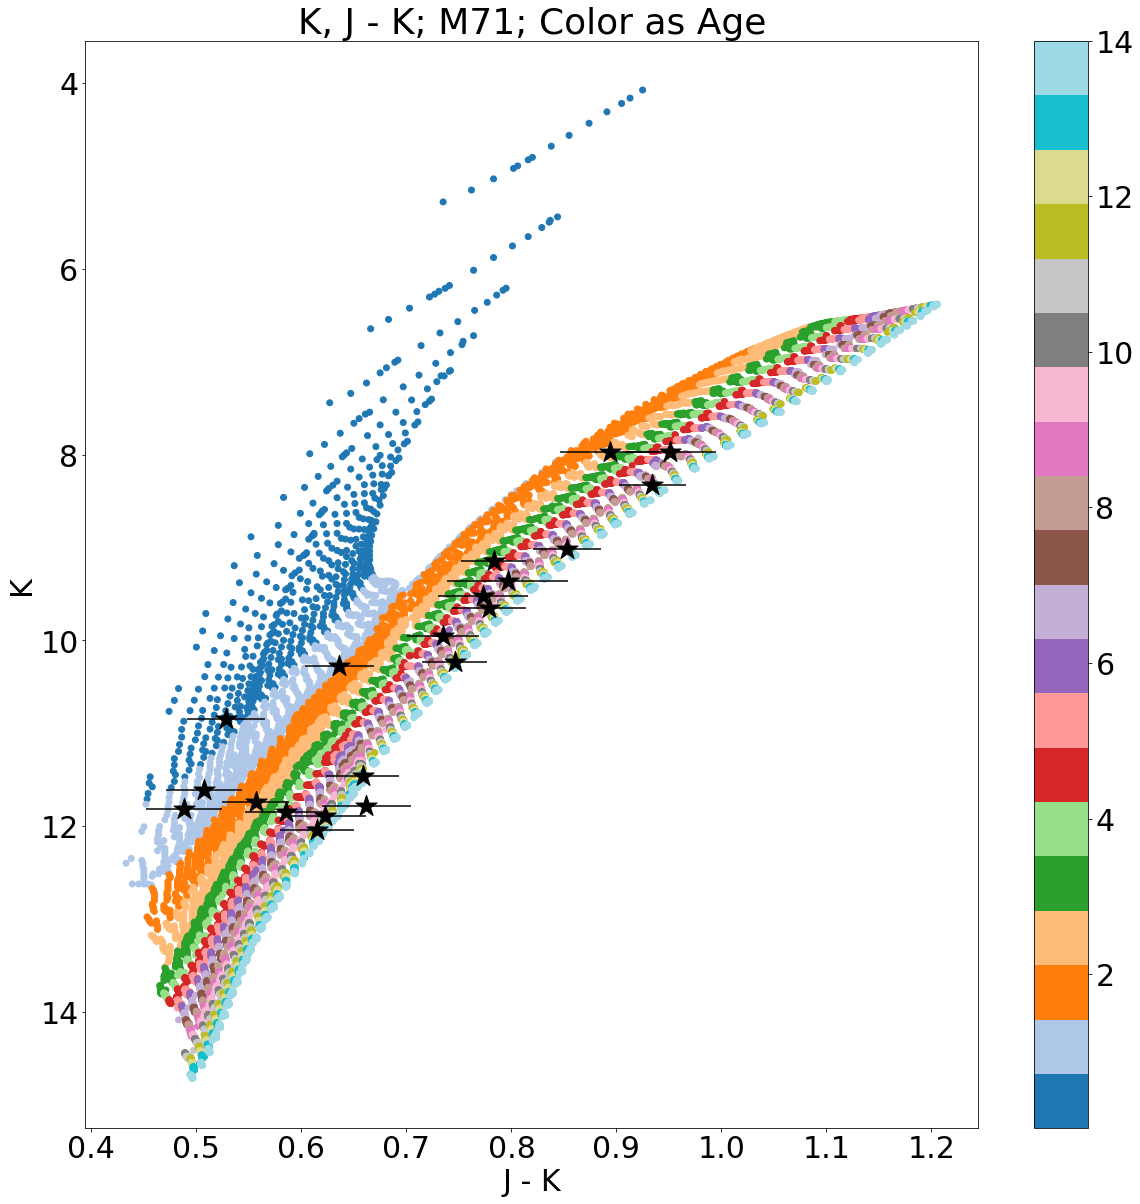

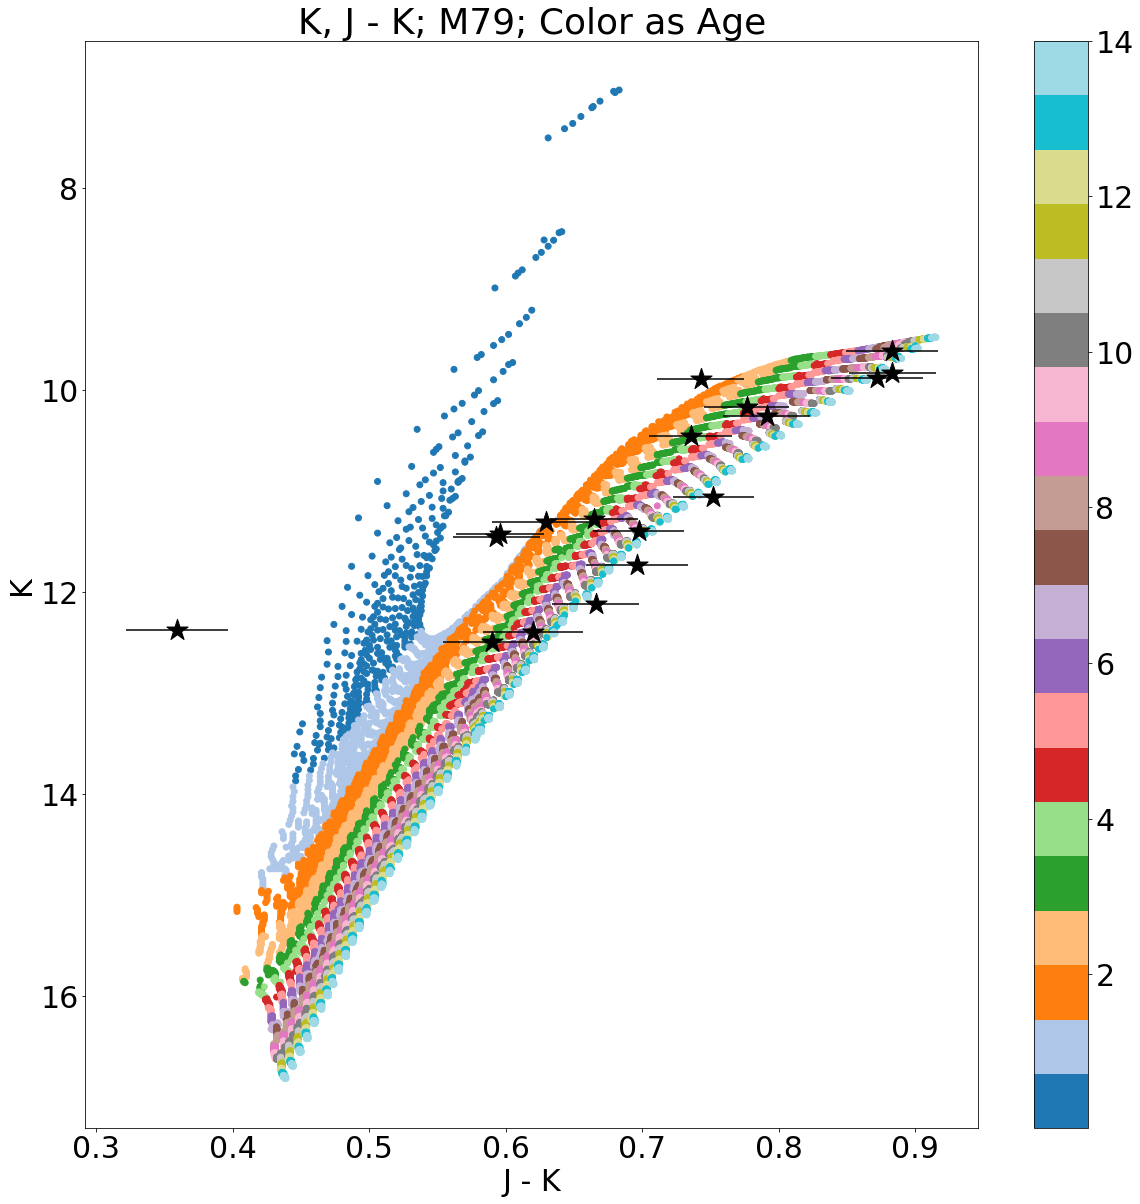

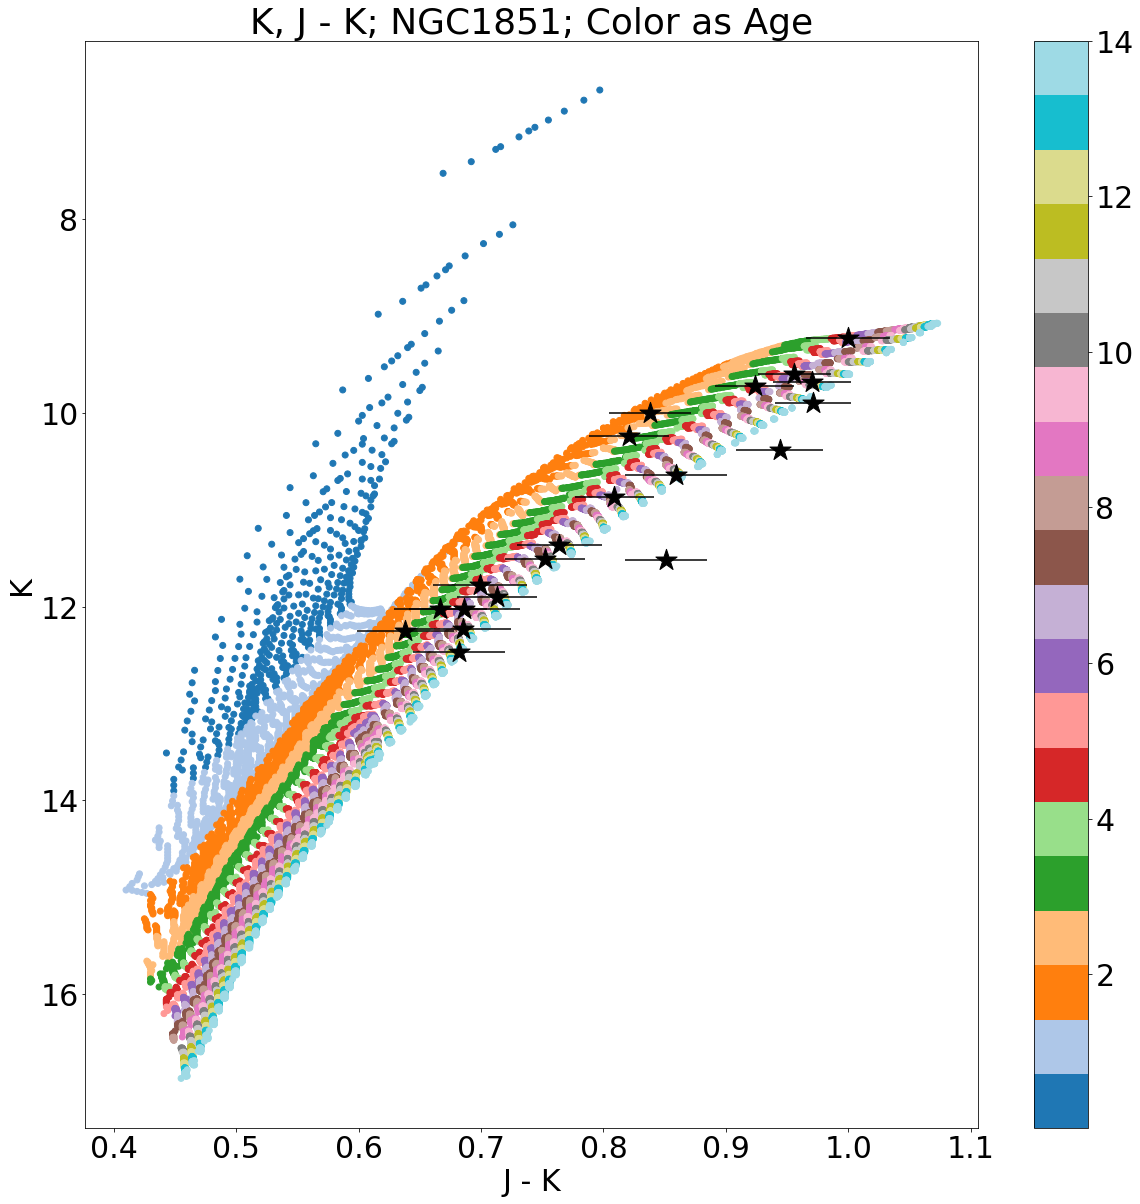

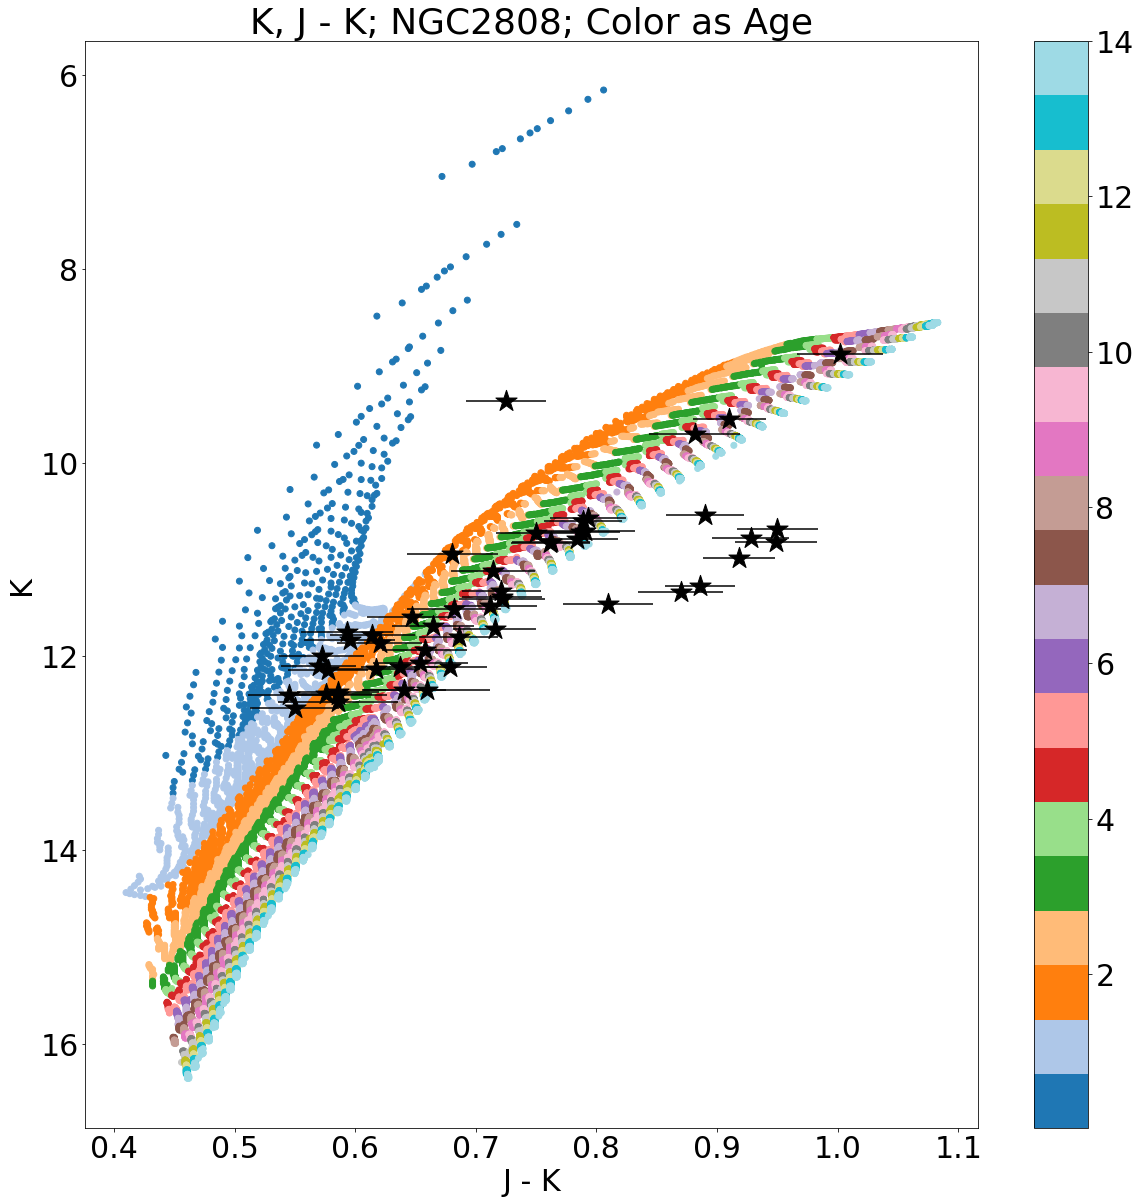

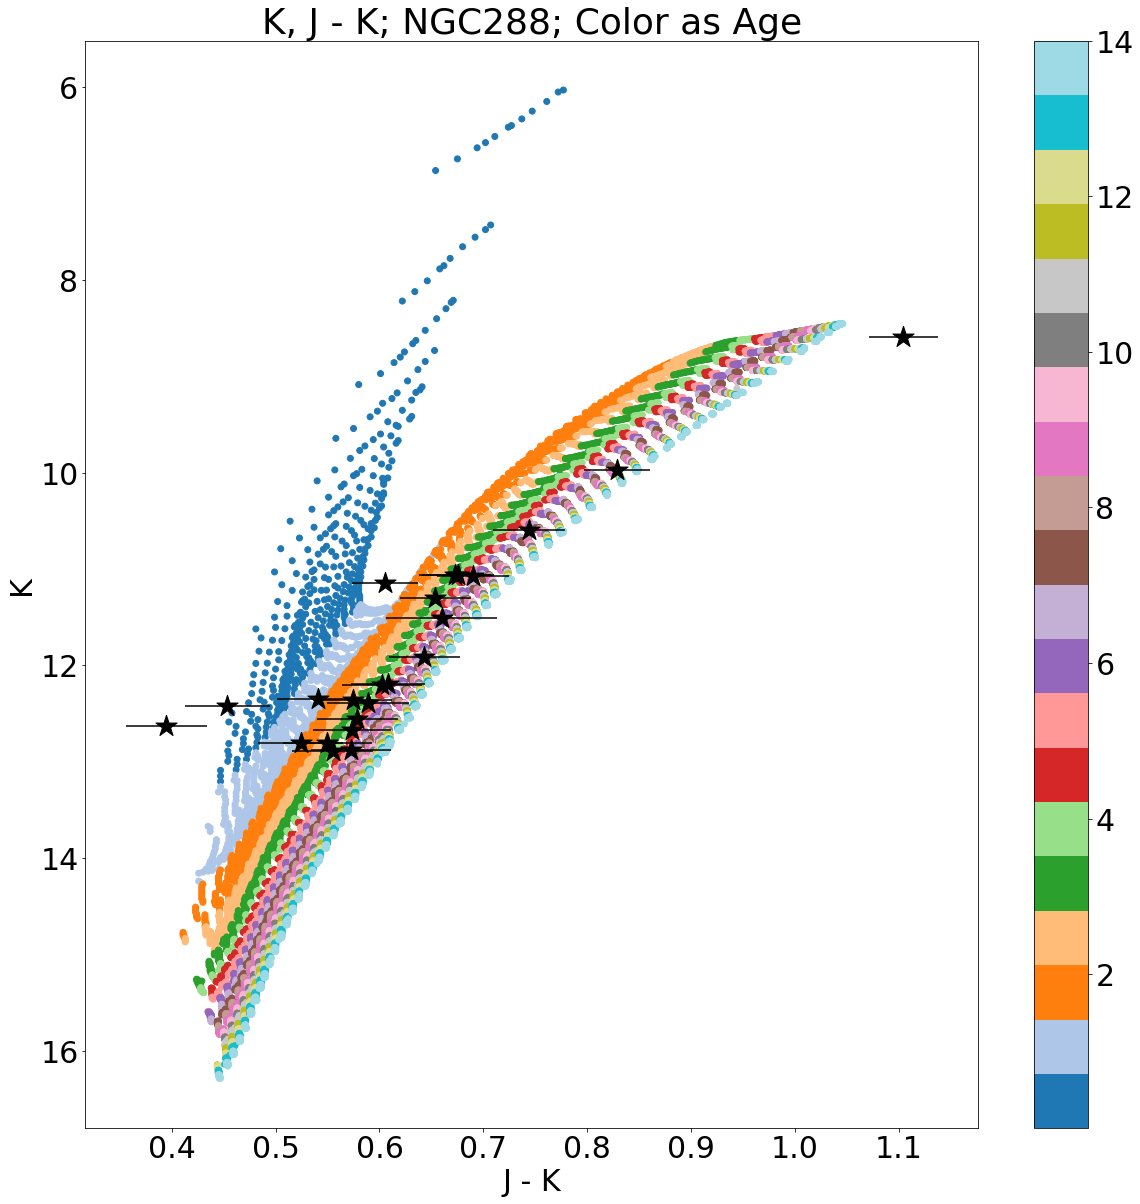

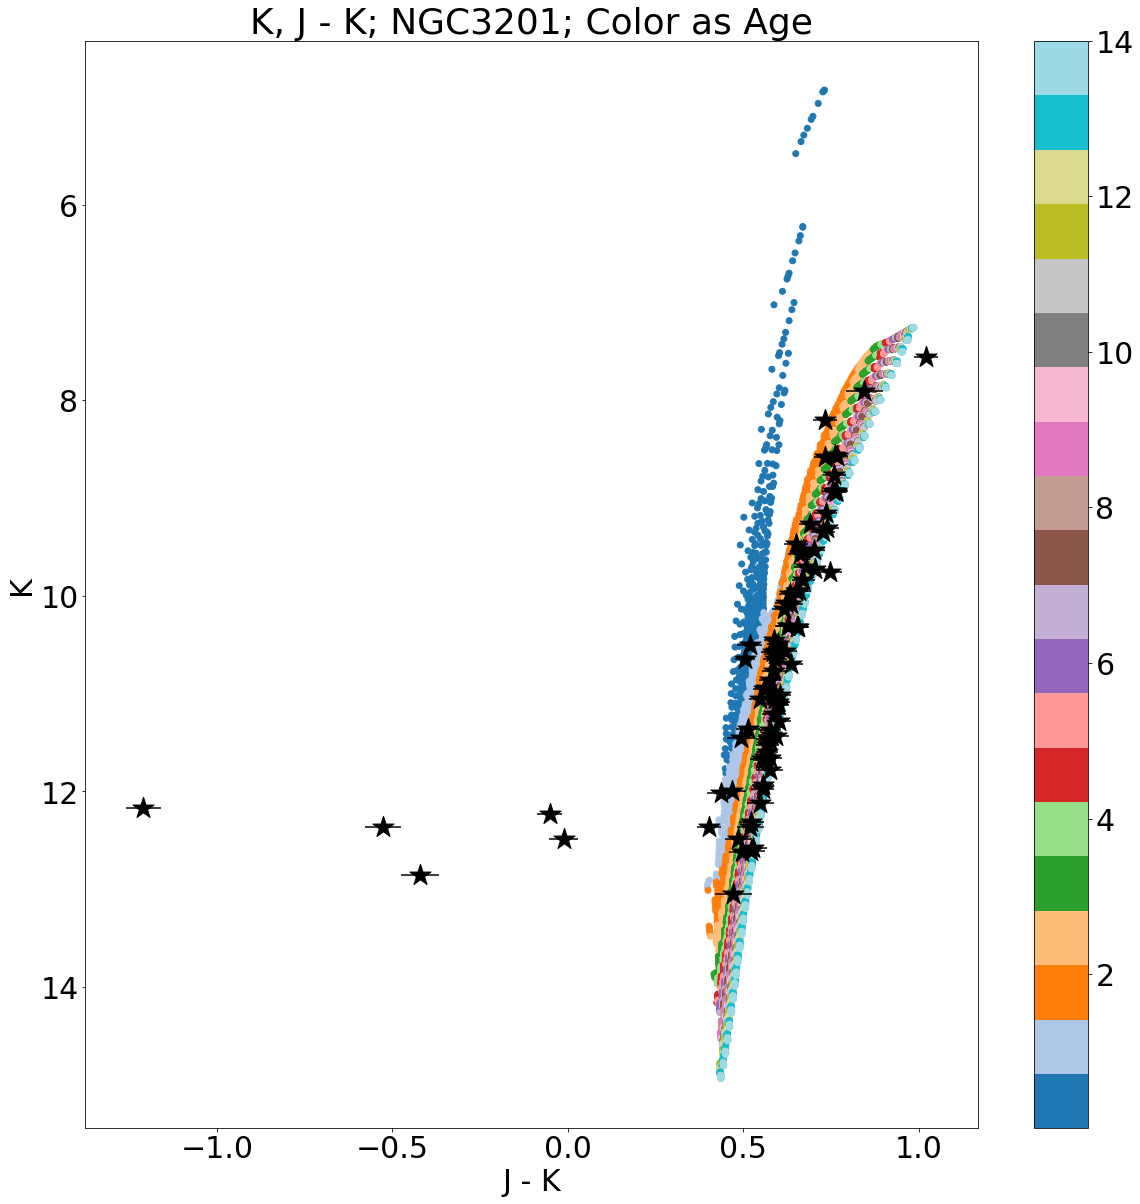

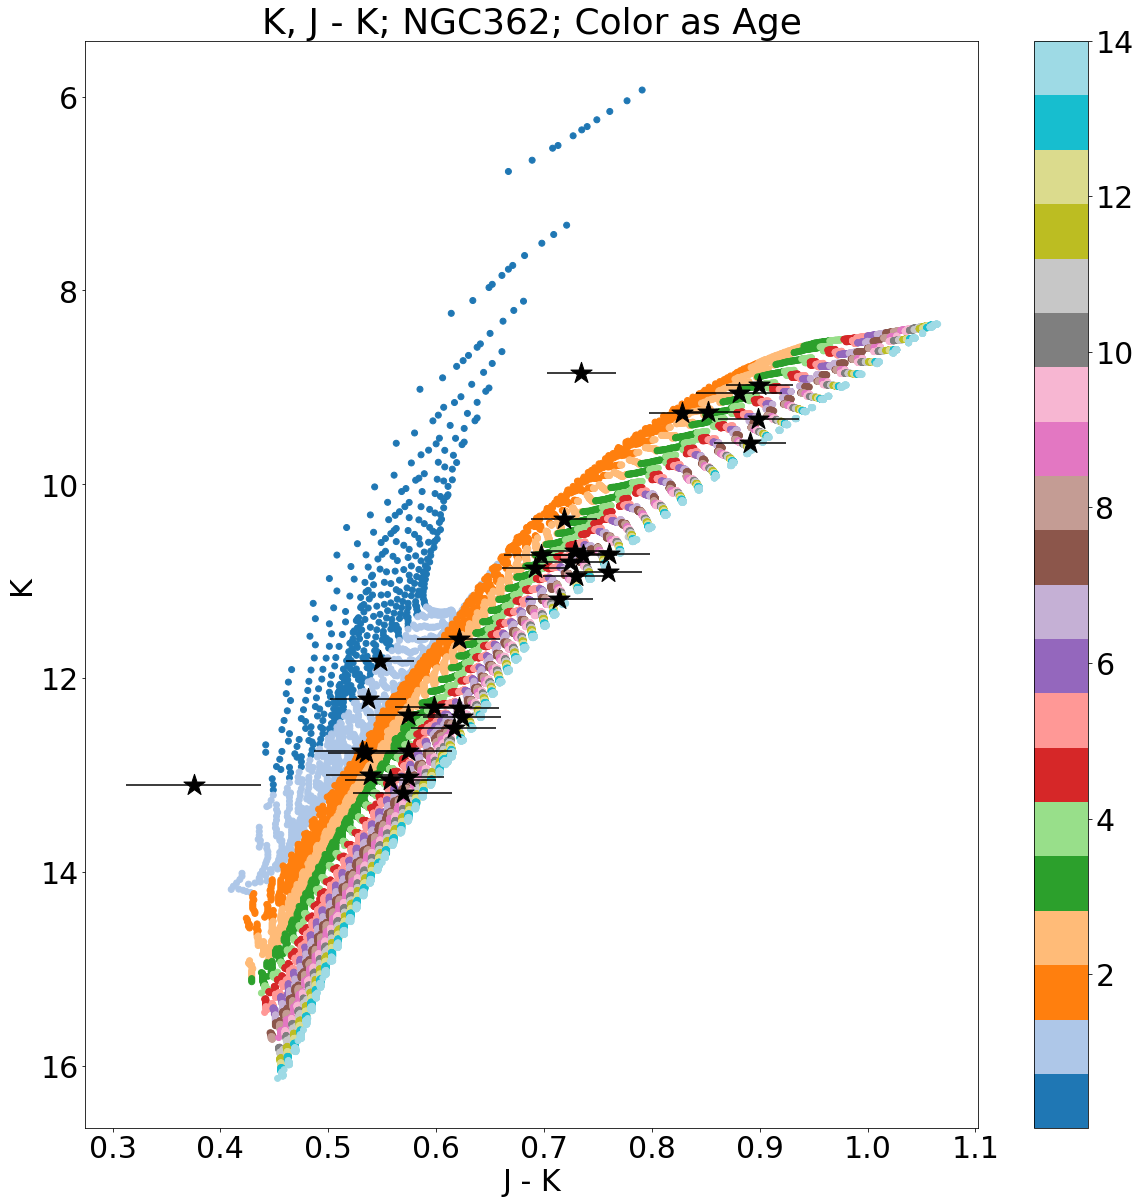

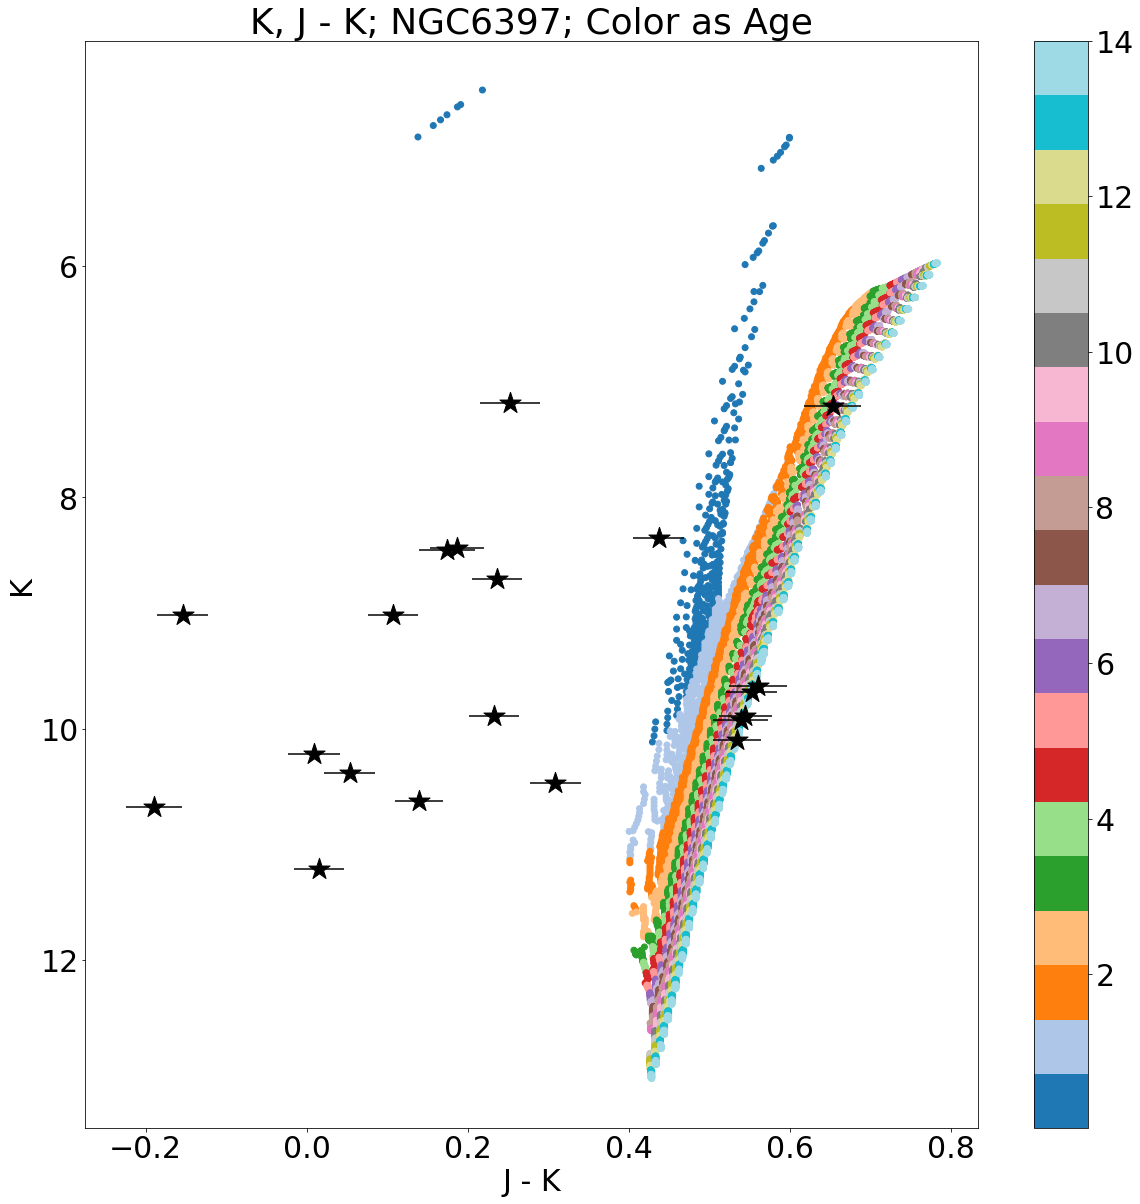

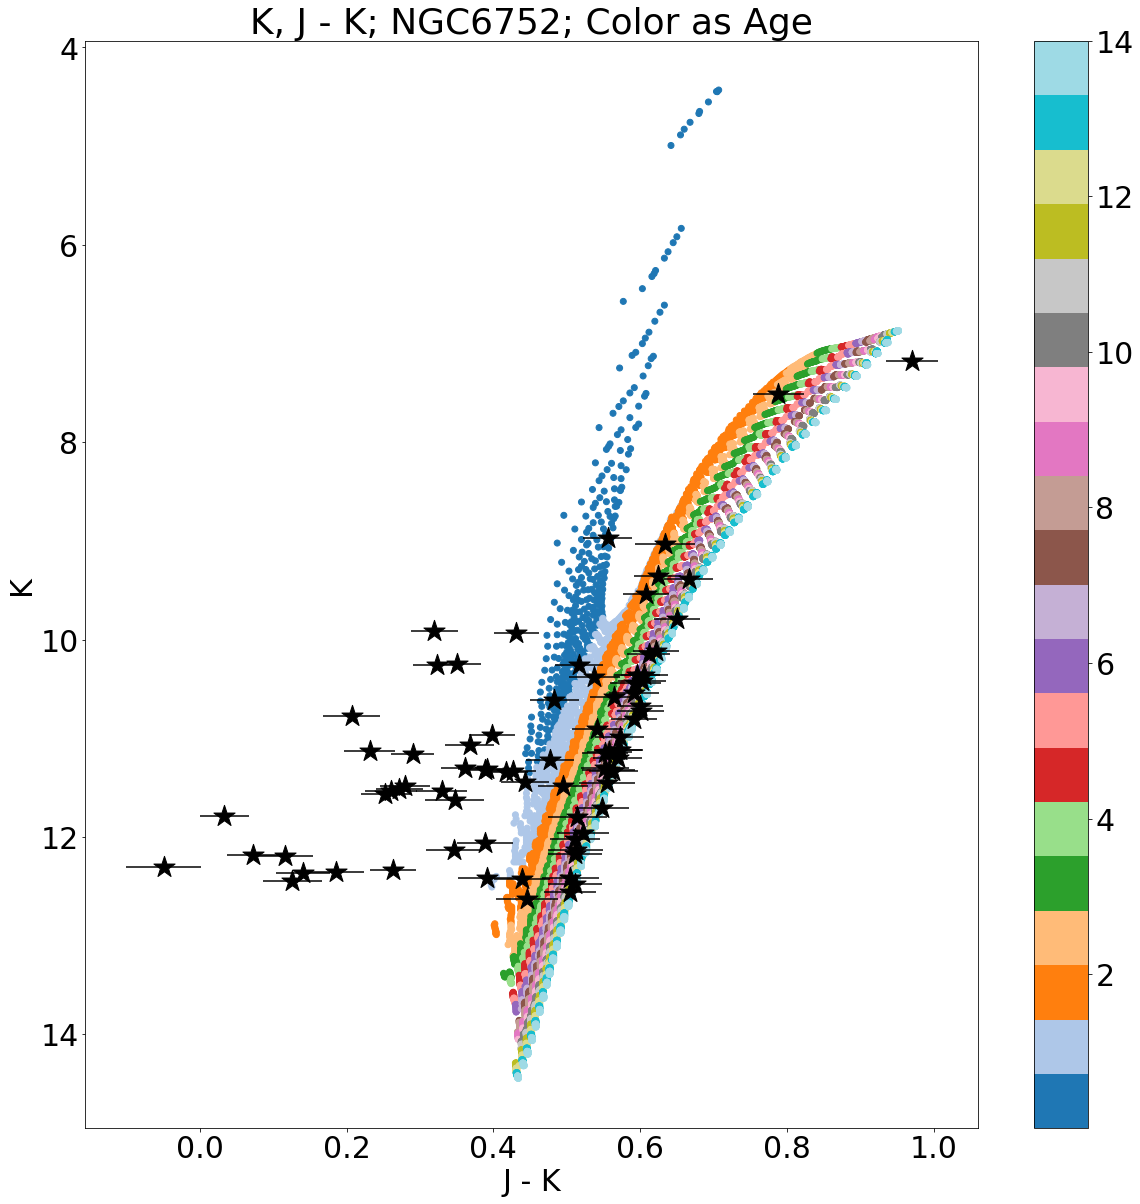

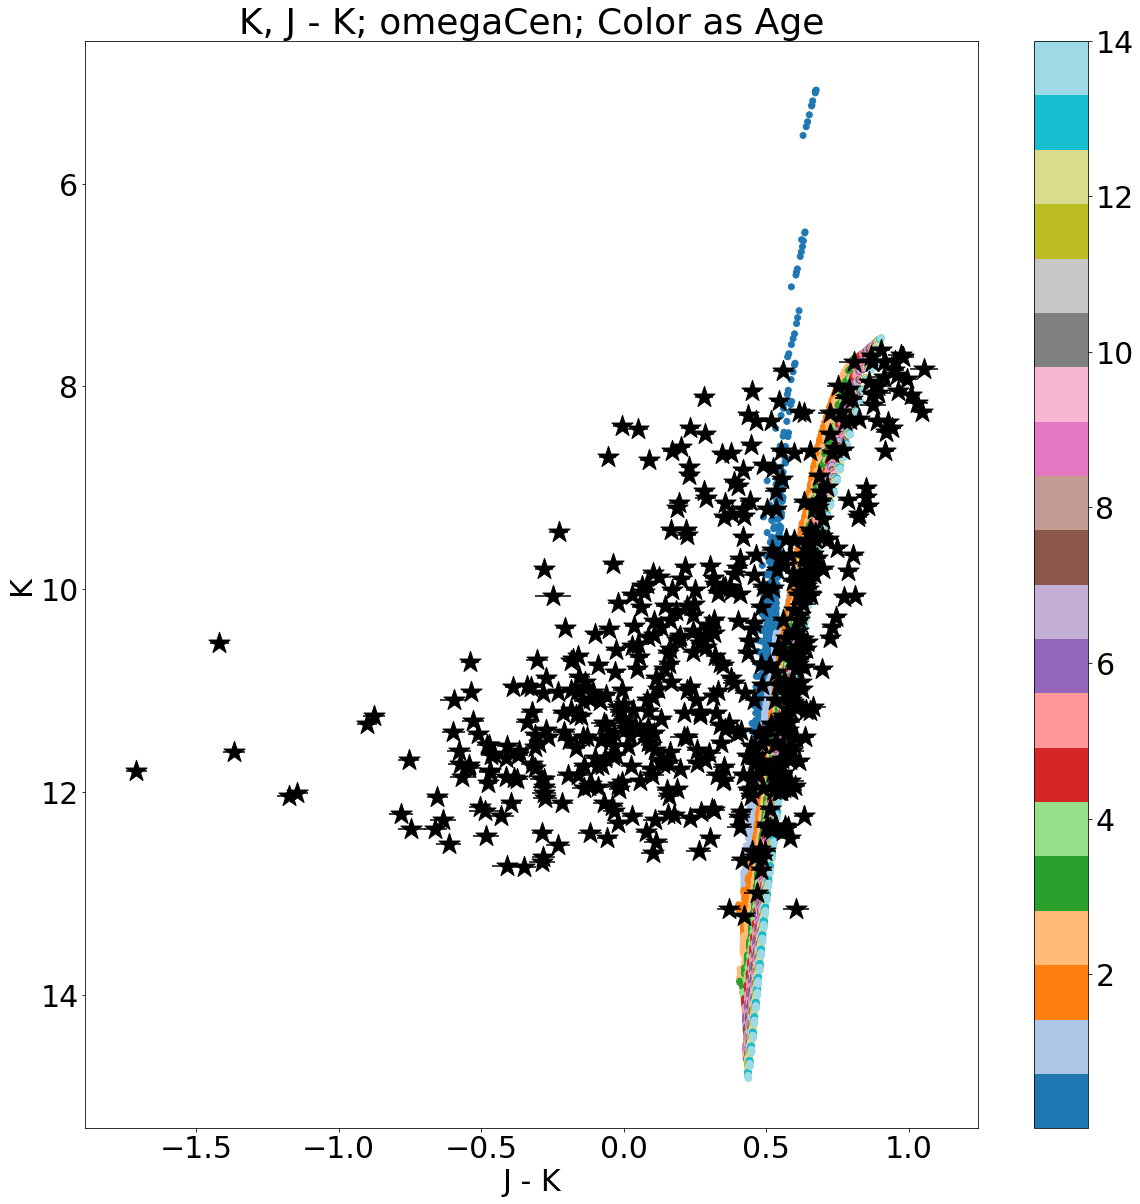

In [482]:
gcs_clus = np.unique(gcs['CLUSTER'])
ejk_ak = (cardelli_alav(leff['J'],3.1)-cardelli_alav(leff['K'],3.1))/cardelli_alav(leff['K'],3.1)
ejk = ejk_ak*best_aks

for i in range(len(gcs_clus)):
    clus = np.where((gcs['CLUSTER']==gcs_clus[i])&(gcs['LOGG']<2.984853))
    isopick = np.where(massive['MH']==closest(massive['MH'],np.nanmedian(gcs['M_H'][clus])+
                                              np.log10(0.638*(10**np.nanmedian(gcs['ALPHA_M'][clus]))+0.362)))
    
    plt.figure(figsize=[20,20])
    plt.scatter((massive['Jmag']-massive['Ksmag'])[isopick],massive['Ksmag'][isopick]+5.*np.log10(harris[i])-5.0,
                c=10**massive['logAge'][isopick]/10**9,cmap='tab20',zorder=0)
    plt.colorbar()
    
#     plt.errorbar((gcs['J']-gcs['K'])[clus],(gcs['K']-5*np.log10(harris[i]*1000)+5)[clus],
#                  xerr=np.sqrt(gcs['J_ERR']**2+gcs['K_ERR']**2)[clus],
#                  yerr=np.sqrt(gcs['K_ERR']**2)[clus],
#                  c='k',ls='none')

    plt.errorbar((gcs['J']-gcs['K']-ejk)[clus],gcs['K'][clus]-best_aks[clus],c='k',
                 xerr=np.sqrt(gcs['K_ERR']**2+gcs['J_ERR']**2)[clus],yerr=gcs['K_ERR'][clus],ls='none')
    
    plt.scatter((gcs['J']-gcs['K']-ejk)[clus],gcs['K'][clus]-best_aks[clus],c='k',marker='*',s=500,zorder=1)
    
    plt.gca().invert_yaxis()
    plt.xlabel(r'J - K')
    plt.ylabel(r'K')
    plt.title(r'K, J - K; {}; Color as Age'.format(gcs_clus[i]))
    plt.savefig('{}_2MASS_w_Best_AK.pdf'.format(gcs_clus[i]))
    plt.show()

(array([1.975e+03, 3.900e+01, 8.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([    0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,  7000.,
         8000.,  9000., 10000.]),
 <a list of 10 Patch objects>)

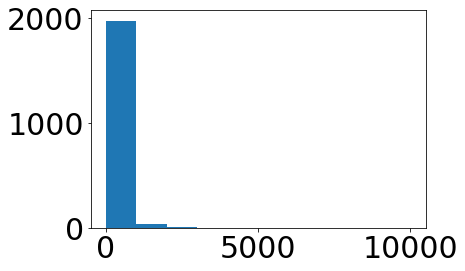

In [446]:
plt.hist(best_chis,range=(0,10000))

In [454]:
theo_mags0 = []
theo_magsak = []

for i in tqdm_notebook(range(len(gcs))):
    CalcAge = WhatsMyAgeAgain(gcs['M_H'][i],gcs['ALPHA_M'][i],gcs_dist[i],massive)
    theo0 = []
    theoak = []
    for j in range(0,14):
        theo0.append(CalcAge.Teff2AppMags(gcs['TEFF'][i],j,0))
        theoak.append(CalcAge.Teff2AppMags(gcs['TEFF'][i],j,best_aks[i]))
    
    theo_mags0.append(theo0)
    theo_magsak.append(theoak)

In [463]:
np.asarray(theo_magsak[0])[:,0]

array([9.99999000e+05, 1.25370472e+01, 1.32575743e+01, 1.37334401e+01,
       1.40281566e+01, 1.42290250e+01, 1.44071580e+01, 1.45698486e+01,
       1.47259228e+01, 1.48657479e+01, 1.50035204e+01, 1.51311560e+01,
       1.52556583e+01, 1.53652641e+01])

In [376]:
theo_mags = []
CalcAge = WhatsMyAgeAgain(gcs['M_H'][idx],gcs['ALPHA_M'][idx],10400,massive)
for i in range(0,14):
    theo_mags.append(CalcAge.Teff2AppMags(gcs['TEFF'][idx],i,0))
    
print(theo_mags)

[array([999999., 999999., 999999.]), array([999999., 999999., 999999.]), array([11.52767419, 10.95211638, 10.86575947]), array([11.75442921, 11.17941365, 11.09266379]), array([11.90373157, 11.32939325, 11.24312671]), array([12.00983677, 11.43541695, 11.34932277]), array([12.0933335 , 11.51914303, 11.43304073]), array([12.16865189, 11.59400287, 11.50794146]), array([12.23247131, 11.65760761, 11.57148055]), array([12.28572322, 11.71037899, 11.62431937]), array([12.33418562, 11.75831521, 11.67232939]), array([12.37648143, 11.80139375, 11.71523914]), array([12.41525967, 11.8402629 , 11.75399535]), array([12.45135398, 11.87547692, 11.78965977])]


In [377]:
# plt.figure(figsize=[10,10])
# plt.plot(np.asarray(theo_mags)[:,0],range(0,14),label='J')
# plt.axhline(bestage,ls='--')
# plt.axvline(gcs['J'][idx],ls='--')
# plt.xlim(10,13)
# plt.ylim(3.,8.)


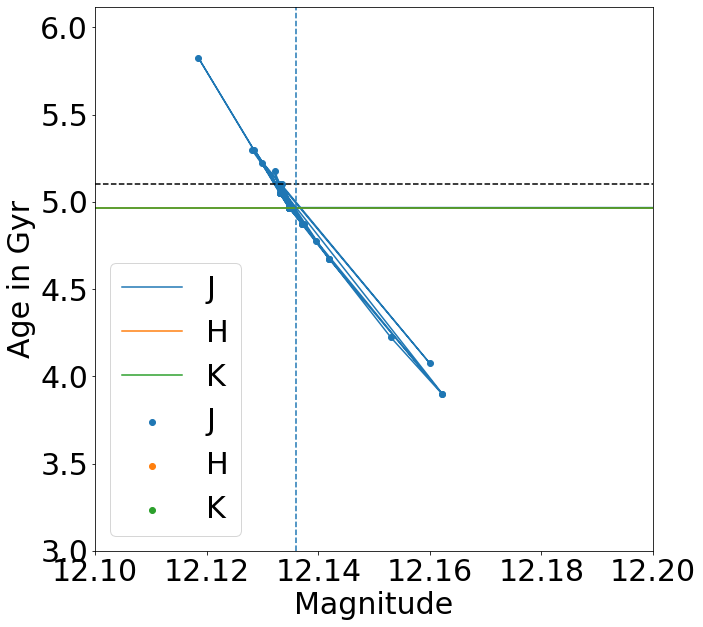

In [378]:
plt.figure(figsize=[10,10])

plt.scatter(np.asarray(cmags)[:,0],age,label='J')
plt.scatter(np.asarray(cmags)[:,1],age,label='H')
plt.scatter(np.asarray(cmags)[:,2],age,label='K')
plt.plot(np.asarray(cmags)[:,0],age,label='J')
plt.plot(np.asarray(cmags)[:,1],age,label='H')
plt.plot(np.asarray(cmags)[:,2],age,label='K')
plt.legend()

plt.axhline(bestage,ls='--',c='k')
plt.axvline(gcs[idx]['J'],ls='--',c='tab:blue')
plt.axvline(gcs[idx]['H'],ls='--',c='tab:orange')
plt.axvline(gcs[idx]['K'],ls='--',c='tab:green')

# plt.xlim(11,12.5)
plt.xlim(12.2,12.10)
plt.ylim(bottom=3.)
plt.gca().invert_xaxis()
plt.xlabel('Magnitude')
plt.ylabel('Age in Gyr')
plt.show()

In [379]:
aj_ak = cardelli_alav(leff['J'],3.1)/cardelli_alav(leff['K'],3.1)
ah_ak = cardelli_alav(leff['H'],3.1)/cardelli_alav(leff['K'],3.1)

exts = np.array([bestak*aj_ak,bestak*ah_ak,bestak])

In [380]:
gcs['CLUSTER'][idx]

'M3'

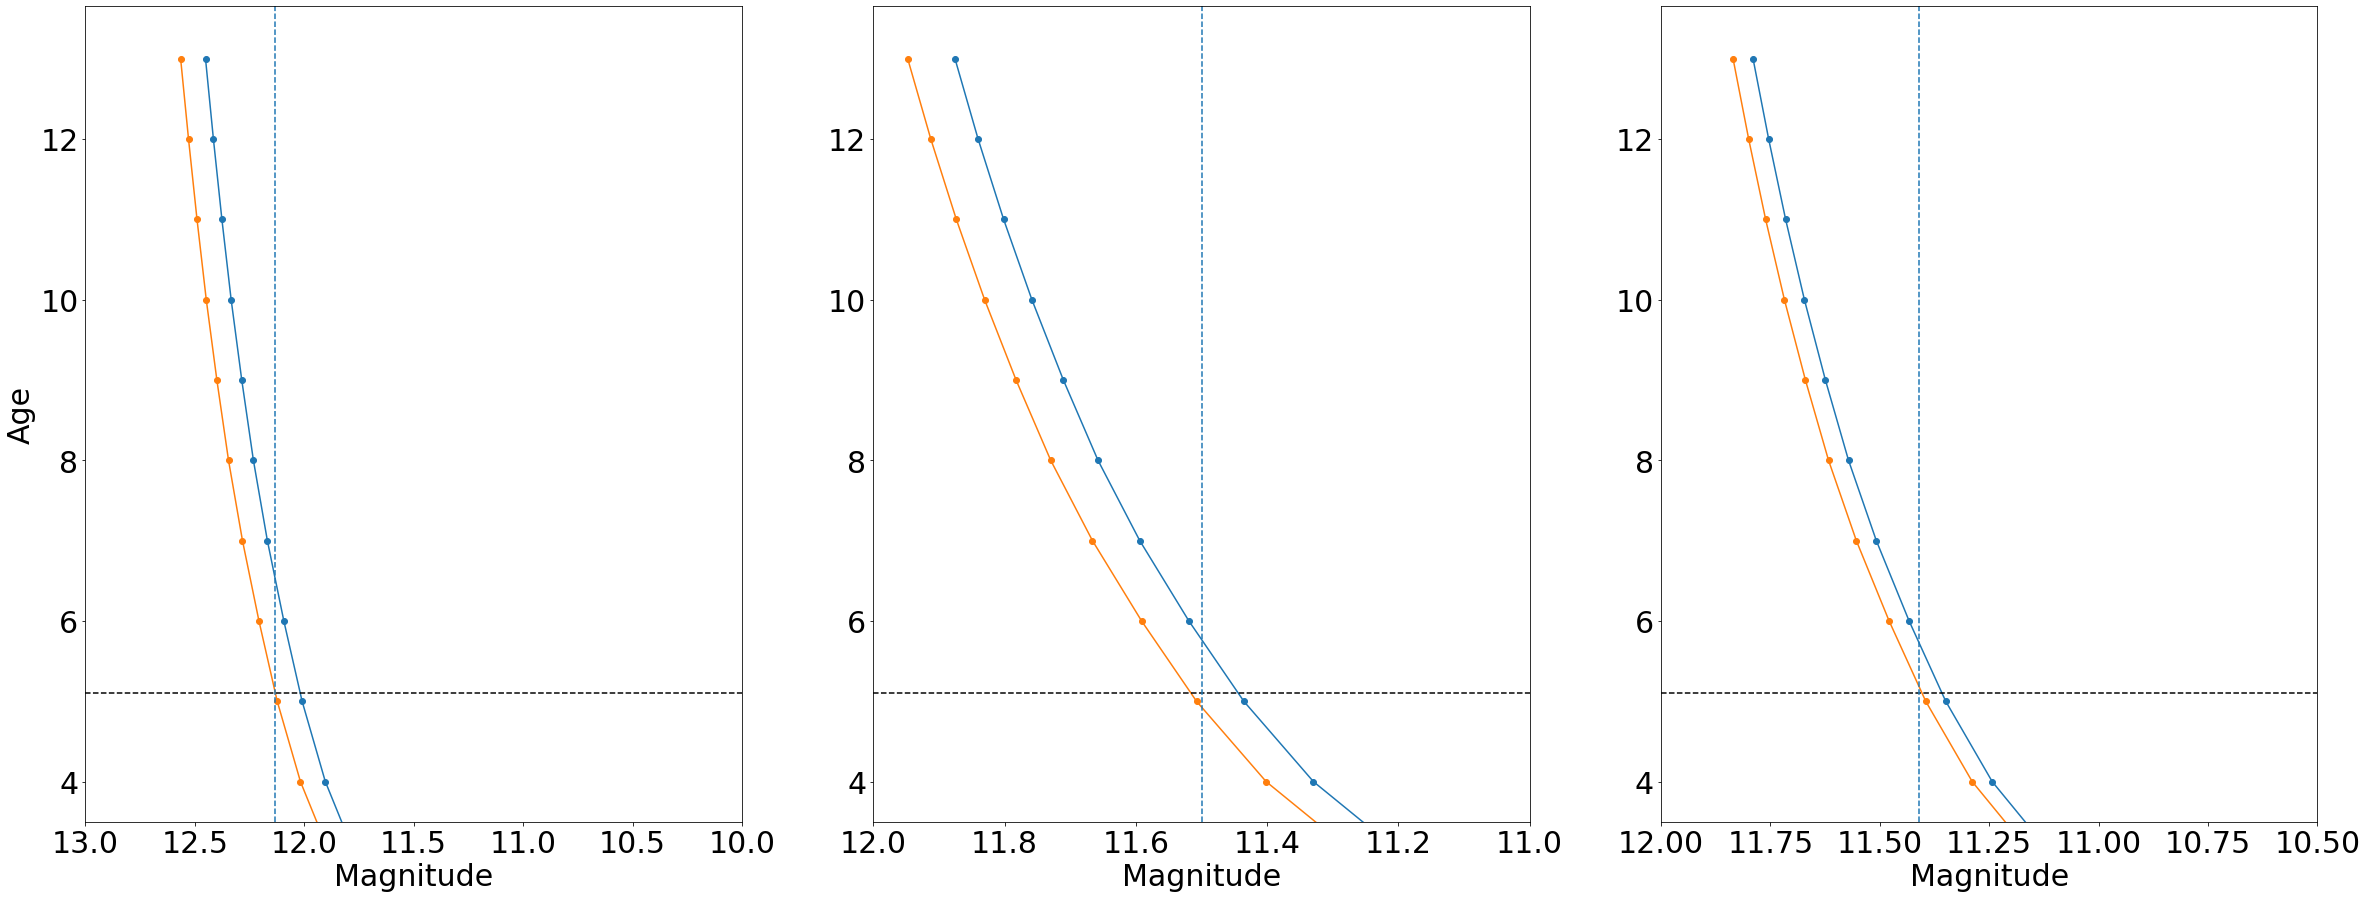

In [381]:
fig, ax = plt.subplots(1,3,figsize=[40,15])
for i in range(3):
    ax[i].scatter(np.asarray(theo_mags)[:,i],range(0,14))
    ax[i].plot(np.asarray(theo_mags)[:,i],range(0,14))
    ax[i].scatter(np.asarray(theo_mags)[:,i]+exts[i],range(0,14))
    ax[i].plot(np.asarray(theo_mags)[:,i]+exts[i],range(0,14))
    ax[i].set_ylim(bottom=3.5)
    ax[i].axhline(bestage,c='k',ls='--')
    ax[i].set_xlabel('Magnitude')

ax[0].axvline(gcs[idx]['J'],ls='--',c='tab:blue')
ax[1].axvline(gcs[idx]['H'],ls='--',c='tab:blue')
ax[2].axvline(gcs[idx]['K'],ls='--',c='tab:blue')

ax[0].set_xlim(13,10)
ax[1].set_xlim(12,11.)
ax[2].set_xlim(12,10.5)

ax[0].set_ylabel('Age')
plt.show()

# M22  Diagnostic Plots

In [4]:
m22_star

NameError: name 'm22_star' is not defined

In [5]:
### M22 Diagnostic Plots

m22_idx, = np.where(gcs['CLUSTER']=='M22')

plt.figure(figsize=[10,10])
plt.hist(best_aks[m22_idx],histtype='step',label='Best Fit')
plt.hist(gcs['AK_TARG'][m22_idx],histtype='step',label='Provided')
plt.legend()
print(np.median(best_aks[m22_idx]))
print(np.median(gcs['AK_TARG'][m22_idx]))
plt.show()

plt.figure(figsize=[10,10])
plt.scatter((gcs['J']-gcs['K'])[m22_idx],(gcs['K']-best_aks)[m22_idx],c='k',marker='*',s=500,zorder=1) 
plt.scatter((gcs['J']-gcs['K'])[1826],(gcs['K']-best_aks)[1826],c='r',marker='*',s=500,zorder=1)
plt.gca().invert_yaxis()
plt.xlabel(r'J - K')
plt.ylabel(r'K')
plt.title(r'M22')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter((gcs['J']-gcs['K']-ejk)[m22_idx],(gcs['K']-best_aks)[m22_idx],c=(gcs['J']-gcs['K'])[m22_idx],
            marker='*',s=500,zorder=1)
plt.colorbar()
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel(r'J - K')
plt.ylabel(r'K')
plt.title(r'M22; Color as J - K with no Dereddening')
plt.show()

NameError: name 'np' is not defined

In [528]:
### Pick Star
# gcs['APOGEE_ID'][m22_idx][np.where((gcs['J']-gcs['K']-ejk)[m22_idx]==min((gcs['J']-gcs['K']-ejk)[m22_idx]))]
# #2M18352706-2402370

# m22_star = np.where(gcs['APOGEE_ID'][m22_idx]=='2M18352706-2402370')
# m22_star

m22_star = np.where((gcs['J']-gcs['K']-ejk)[m22_idx]==closest((gcs['J']-gcs['K']-ejk)[m22_idx],-0.25))
print(gcs[m22_idx][m22_star]['APOGEE_ID'])

m22star = np.where(gcs['APOGEE_ID']=='2M18364754-2350078')
m22star

    APOGEE_ID     
------------------
2M18364754-2350078


(array([1833]),)

(array([85]),)

In [526]:
### Interesting
# len(np.unique(gcs['APOGEE_ID'][m22_idx]))/len(gcs['APOGEE_ID'][m22_idx])
for i in range(len(np.unique(gcs['APOGEE_ID'][m22_idx]))):
    print('{}: {}'.format(np.unique(gcs['APOGEE_ID'][m22_idx])[i],
                          np.where(gcs['APOGEE_ID'][m22_idx]==np.unique(gcs['APOGEE_ID'][m22_idx])[i])))

print('---')
print('2M18365865-2344128: {}'.format(np.where(gcs['APOGEE_ID'][m22_idx]=='2M18365865-2344128')))

2M18351005-2408250: (array([0]),)
2M18351906-2406533: (array([1, 2]),)
2M18352222-2348017: (array([3]),)
2M18352706-2402370: (array([4, 5]),)
2M18353122-2357522: (array([6]),)
2M18353413-2359064: (array([7]),)
2M18353525-2354433: (array([8]),)
2M18353831-2352224: (array([9]),)
2M18354131-2405456: (array([10, 11]),)
2M18354289-2354357: (array([12]),)
2M18354581-2351153: (array([13, 14]),)
2M18354814-2347008: (array([15]),)
2M18354905-2353218: (array([16]),)
2M18355002-2357417: (array([17]),)
2M18355340-2404564: (array([18]),)
2M18355592-2349172: (array([19]),)
2M18355624-2354091: (array([20]),)
2M18355631-2409188: (array([21]),)
2M18355905-2357329: (array([22]),)
2M18360036-2356081: (array([23]),)
2M18360218-2356506: (array([24]),)
2M18360267-2345300: (array([25]),)
2M18360558-2416056: (array([26]),)
2M18360650-2358150: (array([27]),)
2M18360679-2356468: (array([28]),)
2M18360722-2349418: (array([29, 30]),)
2M18360809-2351186: (array([31]),)
2M18360861-2355566: (array([32, 33]),)
2M1836

14.0

In [535]:
(gcs['J']-gcs['K'])[idx]-ejk_ak*0.012113098811889565

0.6179487731694663

In [538]:
print(best_aks[1833])
best_aks[m22_idx][m22_star]

0.5809800724624333


array([0.58098007])

In [540]:
(gcs['J']-gcs['K']-best_aks[m22_idx][m22_star])[m22_idx][m22_star]

<Column name='J' dtype='float64' length=1>
0.05501960710299636

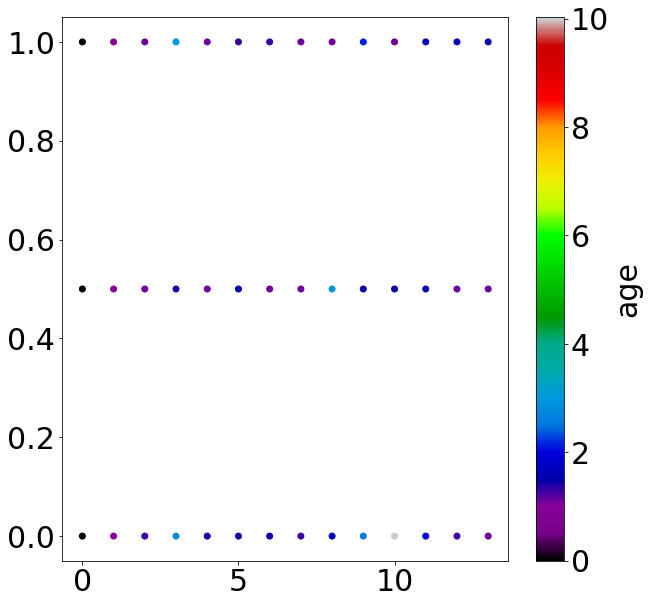

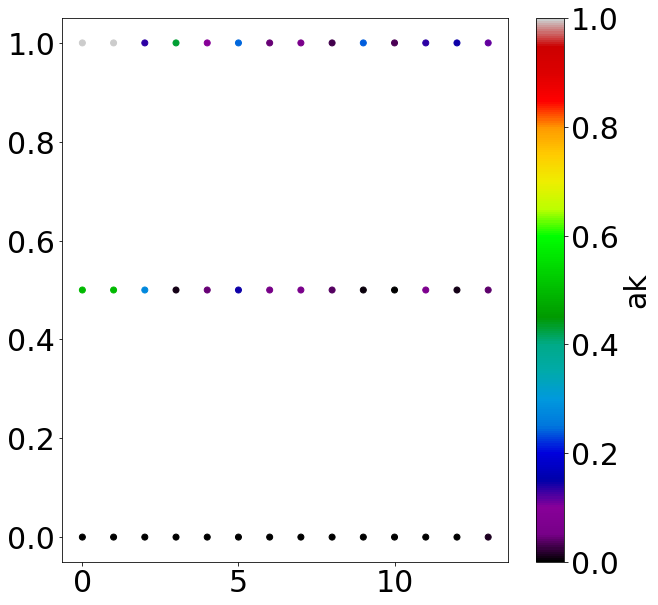

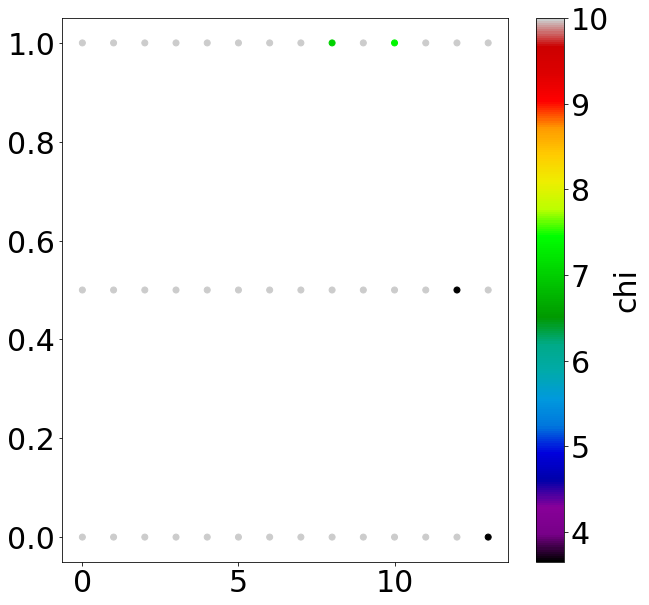

In [530]:
plt.figure(figsize=[10,10])
plt.scatter(initial_age,initial_aks,c=age,cmap='nipy_spectral')
plt.colorbar(label='age')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(initial_age,initial_aks,c=ak,cmap='nipy_spectral')
plt.colorbar(label='ak')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(initial_age,initial_aks,c=chi,cmap='nipy_spectral',vmax=10)
plt.colorbar(label='chi')
plt.show()

In [1]:
initial_ages

NameError: name 'initial_ages' is not defined

ValueError: x and y must be the same size

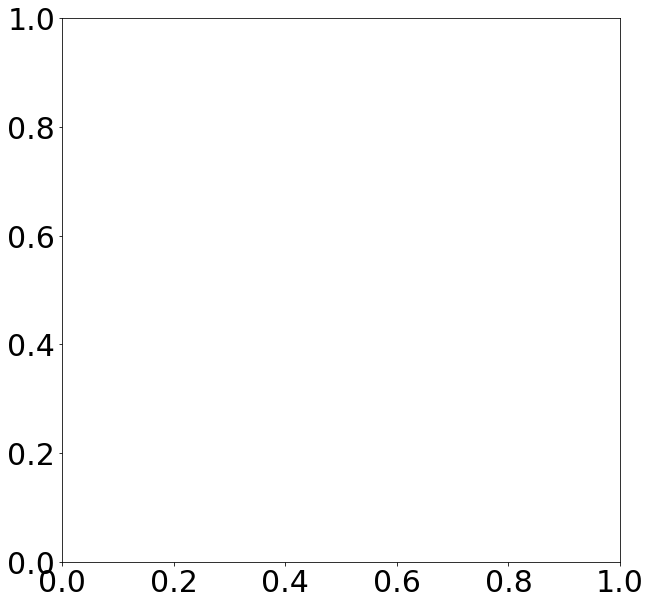

In [523]:
### m22star
plt.figure(figsize=[10,10])
plt.scatter(guess_ages,guess_aks)#,c=age,cmap='nipy_spectral')
plt.colorbar(label='age')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(guess_ages,guess_aks)#,c=ak,cmap='nipy_spectral')
plt.colorbar(label='ak')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(guess_ages,guess_aks)#,c=chi,cmap='nipy_spectral',vmax=10)
plt.colorbar(label='chi')
plt.show()

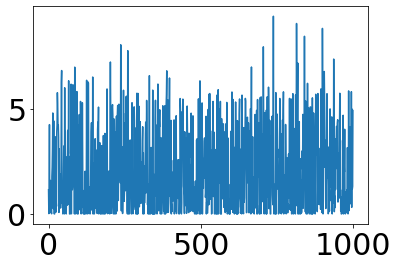

In [385]:
plt.plot(chis)

# Metallicity Check

In [386]:
def MetallicityMatch(teff,logg,isochrones):
    iso_ = Table(isochrones)
    lgteff = np.log10(teff)
    
    euclid = np.subtract(iso_['logTe'],lgteff)**2+np.subtract(iso_['logg'],logg)**2
    feh = iso_['MH'][euclid.argmin()]
    return feh

In [387]:
print('Isochrone Expectation',MetallicityMatch(gcs['TEFF'][1000],gcs['LOGG'][1000],massive))
print('Salaris',round(gcs['M_H'][1000]+np.log10(0.638*(10**gcs['ALPHA_M'][1000])+0.362),2))

Isochrone Expectation -1.05
Salaris -1.29


In [388]:
iso_exp = 999999.0*np.ones(len(gcs))
for i in tqdm_notebook(range(len(gcs))):
    iso_exp[i] = MetallicityMatch(gcs['TEFF'][i],gcs['LOGG'][i],massive)

sal_exp = np.round(gcs['M_H']+np.log10(0.638*(10**gcs['ALPHA_M'])+0.362),2)

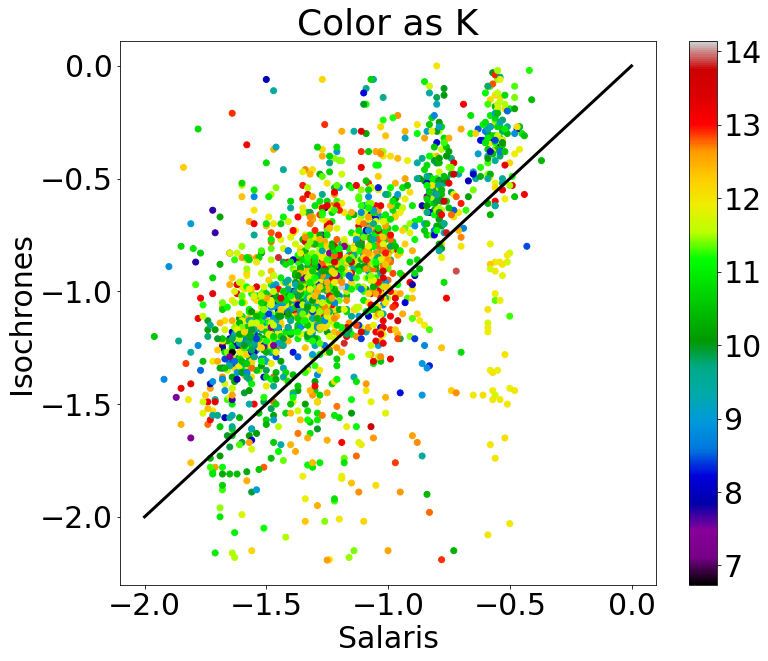

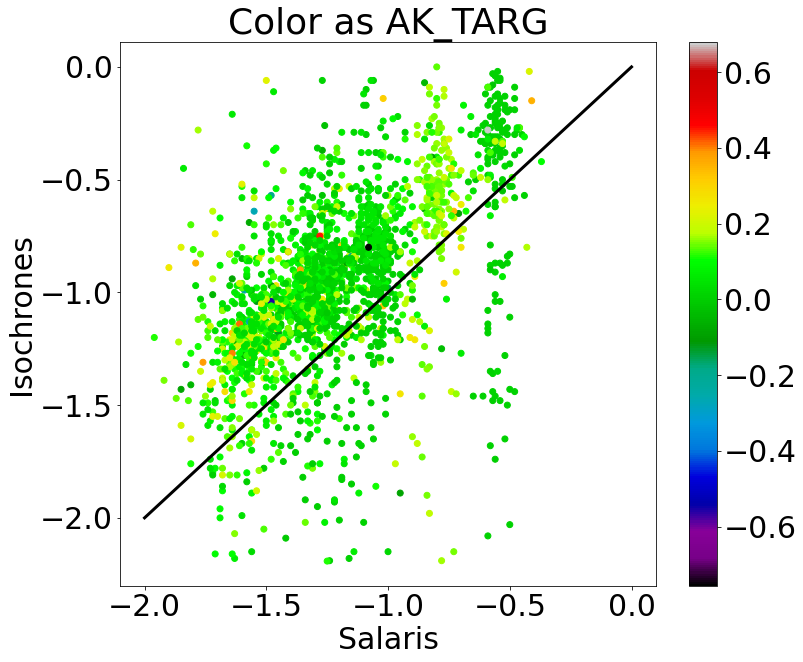

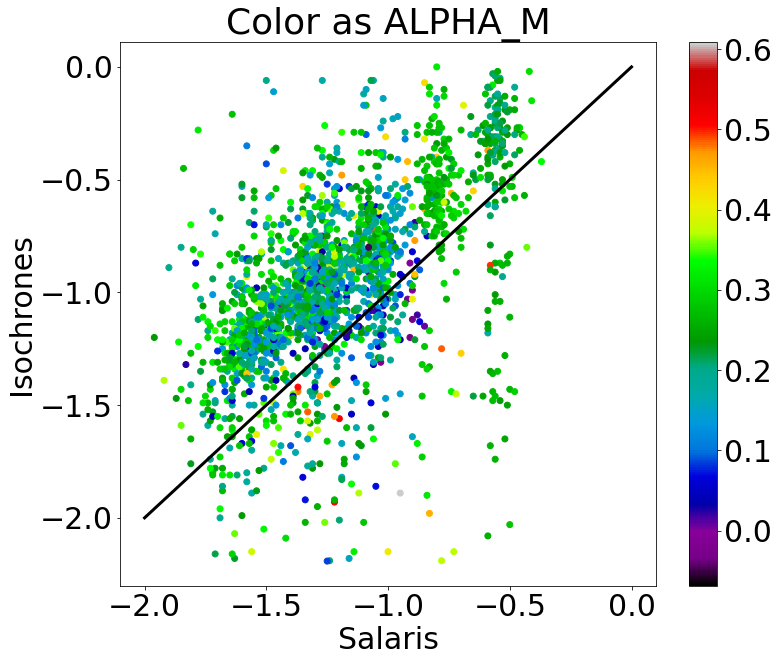

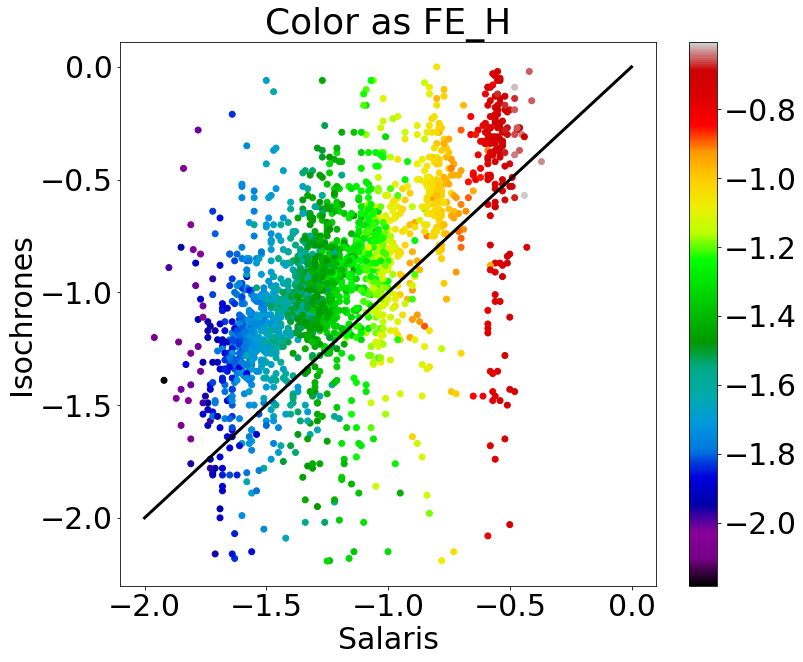

In [389]:
plt.figure(figsize=[12,10])
plt.scatter(sal_exp,iso_exp,c=gcs['K'],cmap='nipy_spectral')
plt.colorbar()
plt.plot([-2,0],[-2,0],c='k',lw=3.0)
plt.title(r'Color as K')
plt.xlabel(r'Salaris')
plt.ylabel(r'Isochrones')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(sal_exp,iso_exp,c=gcs['AK_TARG'],cmap='nipy_spectral')
plt.colorbar()
plt.plot([-2,0],[-2,0],c='k',lw=3.0)
plt.title(r'Color as AK_TARG')
plt.xlabel(r'Salaris')
plt.ylabel(r'Isochrones')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(sal_exp,iso_exp,c=gcs['ALPHA_M'],cmap='nipy_spectral')
plt.colorbar()
plt.plot([-2,0],[-2,0],c='k',lw=3.0)
plt.title(r'Color as ALPHA_M')
plt.xlabel(r'Salaris')
plt.ylabel(r'Isochrones')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(sal_exp,iso_exp,c=gcs['FE_H'],cmap='nipy_spectral')
plt.colorbar()
plt.plot([-2,0],[-2,0],c='k',lw=3.0)
plt.title(r'Color as FE_H')
plt.xlabel(r'Salaris')
plt.ylabel(r'Isochrones')
plt.show()